# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
from umap import UMAP
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:20,.2f}'.format

/home/user/.local/share/virtualenvs/labo-a041pJnc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [2]:
def clase_renta(renta,max = 35000, big = 18000,low=1000):
    if renta > max:
        return 3
    elif renta > big:
        return 2
    elif renta > low:
        return 1
    else:
        return 0

def agrupar_edades(edad):
    if edad <= 25:
        return 'h/25'
    elif edad <= 35:
        return '26 a 35'
    elif edad <= 45:
        return '36 a 45'
    elif edad <= 55:
        return '46 a 55'
    elif edad <= 65:
        return '56 a 65'
    else:
        return '65+'

def edad_split(edad):
    if edad <= 45:
        return 'h/45'
    else:
        return '45+'

In [3]:
df_train = pd.read_csv("./../../../datasets/exp_4_TRAINING_STRATEGY_miranda_15_dataset_training.csv.gz")



In [4]:
df_train_pr = df_train[['cprestamos_personales','cprestamos_prendarios','cprestamos_hipotecarios','cplazo_fijo','cinversion1','cinversion2','cseguro_vida','cseguro_auto','cseguro_vivienda','cseguro_accidentes_personales','ccaja_seguridad']]
df_train['productos_premium'] = df_train_pr.apply(lambda x: x['cprestamos_personales']+x['cprestamos_prendarios']+x['cprestamos_hipotecarios']+x['cplazo_fijo']+x['cinversion1']+x['cinversion2']+x['cseguro_vida']+x['cseguro_auto']+x['cseguro_vivienda']+x['cseguro_accidentes_personales']+x['ccaja_seguridad'],axis=1)
del df_train_pr
df_hab = df_train[['mpayroll','mpayroll_max8']]
df_train['perdio_haberes'] = df_hab.apply(lambda x: 1 if x['mpayroll']==0 and x['mpayroll_max8']>0 else 0,axis=1)
del df_hab

In [5]:
df_train = df_train.drop(['azar_under','azar_sampling','fold_train','fold_test'],axis=1)

df_train['edad_ag'] = df_train.cliente_edad.apply(agrupar_edades)
df_train['edad_ag'] = df_train['edad_ag'].astype('category')
df_train['edad_ag'] = df_train['edad_ag'].cat.reorder_categories(['h/25', '26 a 35','36 a 45', '46 a 55', '56 a 65','65+'])

df_train['edad_split'] = df_train.cliente_edad.apply(edad_split)
df_train['edad_split'] = df_train['edad_split'].astype('category')
df_train['edad_split'] = df_train['edad_split'].cat.reorder_categories(['h/45','45+'])

df_train['renta_clase'] = df_train.mrentabilidad_annual.apply(clase_renta)

df_train['uso_app_bool'] = df_train.cmobile_app_trx.apply(lambda x: 1 if x>=1 else 0)



In [6]:
#Xtrain = df_train[df_train["foto_mes"] == 202105 ]
#Xtrain = df_train
Xtrain = df_train.query("foto_mes in [202105,202104]")
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [7]:
Xbajas = df_train.query("clase_ternaria != 'CONTINUA' & foto_mes < 202104")

In [8]:
Xbajas.groupby('foto_mes').count()

numero_de_cliente  active_quarter  cliente_vip  cliente_edad  \
foto_mes                                                                 
202007                  172             172          172           172   
202008                  142             142          142           142   
202009                  127             127          127           127   
202010                  160             160          160           160   
202011                  180             180          180           180   
202012                  217             217          217           217   
202101                  253             253          253           253   
202102                  284             284          284           284   
202103                  327             327          327           327   

          cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
foto_mes                                                            
202007                   172            172                   172   
202008                   142            142                   142   
202009                   127            127                   127   
202010                   160            160                   160   
202011                   180            180                   180   
202012                   217            217                   217   
202101                   253            253                   253   
202102                   284            284                   284   
202103                   327            327                   327   

          mcomisiones  mactivos_margen  mpasivos_margen  ...  \
foto_mes                                                 ...   
202007            172              172              172  ...   
202008            142              142              142  ...   
202009            127              127              127  ...   
202010            160              160              160  ...   
202011            180              180              180  ...   
202012            217              217              217  ...   
202101            253              253              253  ...   
202102            284              284              284  ...   
202103            327              327              327  ...   

          vmr_mconsumototal_max8  vmr_mpagominimo_min8  vmr_mpagominimo_max8  \
foto_mes                                                                       
202007                       171                   171                   171   
202008                       140                   140                   140   
202009                       126                   126                   126   
202010                       160                   160                   160   
202011                       179                   179                   179   
202012                       214                   214                   214   
202101                       250                   250                   250   
202102                       283                   283                   283   
202103                       326                   326                   326   

          fold_validate  productos_premium  perdio_haberes  edad_ag  \
foto_mes                                                              
202007              172                172             172      172   
202008              142                142             142      142   
202009              127                127             127      127   
202010              160                160             160      160   
202011              180                180             180      180   
202012              217                217             217      217   
202101              253                253             253      253   
202102              284                284             284      284   
202103              327                327             327      327   

          edad_split  renta_clase  uso_app_bool  
foto_mes         

Y nos deshacemos del target y limpiamos un poco la memoria.

In [9]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

Hacemos un modelo **LGBM**

In [10]:
# create dataset for lightgbm
#lgb_train = lgb.Dataset(Xtrain[Xtrain.columns.difference(['uso_app_bool', 'edad_split'])], ytrain)
df = Xtrain.copy()
lgb_train = lgb.Dataset(Xtrain[Xtrain.columns.difference(['foto_mes'])], ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
    'random_state':539141
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.826587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Y miramos su importancia de variables

In [11]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


Features  Importances
366                   mcuentas_saldo           69
414            mprestamos_personales           67
455                productos_premium           66
165        ccallcenter_transacciones           58
301   ctransferencias_recibidas_max8           48
..                               ...          ...
339  mcheques_depositados_rechazados            0
338        mcheques_depositados_min8            0
337        mcheques_depositados_max8            0
336             mcheques_depositados            0
0                 Master_Finiciomora            0

[593 rows x 2 columns]

In [12]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas[Xbajas.columns.difference(['foto_mes'])])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [14]:
# df['edad_ag'] = df.cliente_edad.apply(agrupar_edades)
# df['edad_ag'] = df['edad_ag'].astype('category')
# df['edad_ag'] = df['edad_ag'].cat.reorder_categories(['hasta 25', '26 a 35','36 a 45', '46 a 55', '56 a 65','mayor de 65'])

# df['edad_split'] = df.cliente_edad.apply(edad_split)
# df['renta_clase'] = df.mrentabilidad_annual.apply(clase_renta)
# df['uso_app_bool'] = df.cmobile_app_trx.apply(lambda x: 'sí' if x>=1 else 'no')

# Xbajas['edad_ag'] = Xbajas.cliente_edad.apply(agrupar_edades)
# Xbajas['edad_ag'] = Xbajas['edad_ag'].astype('category')
# Xbajas['edad_ag'] = Xbajas['edad_ag'].cat.reorder_categories(['hasta 25', '26 a 35','36 a 45', '46 a 55', '56 a 65','mayor de 65'])

# Xbajas['edad_split'] = Xbajas.cliente_edad.apply(edad_split)
# Xbajas['renta_clase'] = Xbajas.mrentabilidad_annual.apply(clase_renta)
# Xbajas['uso_app_bool'] = Xbajas.cmobile_app_trx.apply(lambda x: 'sí' if x>=1 else 'no')

In [13]:
del Xtrain
df = pd.concat([df.reset_index(),ytrain.reset_index()],axis=1).rename(columns={'clase_ternaria':'target'})
del ytrain


Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [14]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas[Xbajas.columns.difference(['foto_mes'])].columns)
shap_bajas

Master_Finiciomora  Master_Finiciomora_max8  Master_Finiciomora_min8  \
0                    0.00                     0.00                     0.00   
1                    0.00                     0.00                     0.00   
2                    0.00                     0.00                     0.00   
3                    0.00                     0.00                     0.00   
4                    0.00                     0.00                     0.00   
...                   ...                      ...                      ...   
1857                 0.00                     0.00                     0.00   
1858                 0.00                     0.00                     0.00   
1859                 0.00                     0.00                     0.00   
1860                 0.00                     0.00                     0.00   
1861                 0.00                     0.00                     0.00   

      Master_Fvencimiento  Master_Fvencimiento_max8  Master_Fvencimiento_min8  \
0                   -0.01                     -0.00                     -0.00   
1                   -0.00                     -0.01                     -0.01   
2                   -0.00                     -0.00                     -0.01   
3                   -0.00                      0.00                     -0.01   
4                   -0.00                     -0.00                      0.00   
...                   ...                       ...                       ...   
1857                 0.01                      0.00                      0.02   
1858                 0.02                     -0.00                      0.00   
1859                 0.02                      0.00                      0.01   
1860                 0.01                      0.00                      0.03   
1861                 0.01                     -0.00                      0.02   

      Master_cadelantosefectivo  Master_cadelantosefectivo_max8  \
0                         -0.00                            0.00   
1                         -0.00                            0.00   
2                          0.00                            0.00   
3                         -0.00                            0.00   
4                         -0.00                            0.00   
...                         ...                             ...   
1857                      -0.00                            0.00   
1858                      -0.00                            0.00   
1859                      -0.00                            0.00   
1860                      -0.00                            0.00   
1861                      -0.00                            0.00   

      Master_cadelantosefectivo_min8     Master_cconsumos  ...  \
0                               0.00                -0.00  ...   
1                               0.00                -0.00  ...   
2                               0.00                 0.01  ...   
3                               0.00                -0.00  ...   
4                               0.00                -0.00  ...   
...                              ...                  ...  ...   
1857                            0.00                -0.00  ...   
1858                            0.00                -0.00  ...   
1859                            0.00                -0.00  ...   
1860                            0.00                -0.00  ...   
1861                            0.00                -0.00  ...   

      vmr_msaldodolares_min8      vmr_msaldopesos     vmr_msaldopesos2  \
0                       0.00                -0.00                -0.00   
1                       0.00                -0.01                -0.01   
2                       0.00                -0.01                -0.00   
3                       0.00                -0.00                -0.00   
4                       0.00                -0.00                 0.00   
...                      ...               

Y consolidamos sus importancias

In [15]:
shap_importancias = shap_bajas.mean().abs().sort_values(ascending=False)
shap_importancias

ctrx_quarter_normalizado                           0.64
cpayroll_trx                                       0.31
ctrx_quarter                                       0.24
cpayroll_trx_min8                                  0.18
mcuentas_saldo                                     0.14
                                           ...         
mcajeros_propios_descuentos_min8                   0.00
mcajeros_propios_descuentos_max8                   0.00
mcajeros_propios_descuentos                        0.00
Visa_mconsumototal                                 0.00
Master_Finiciomora                                 0.00
Length: 593, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

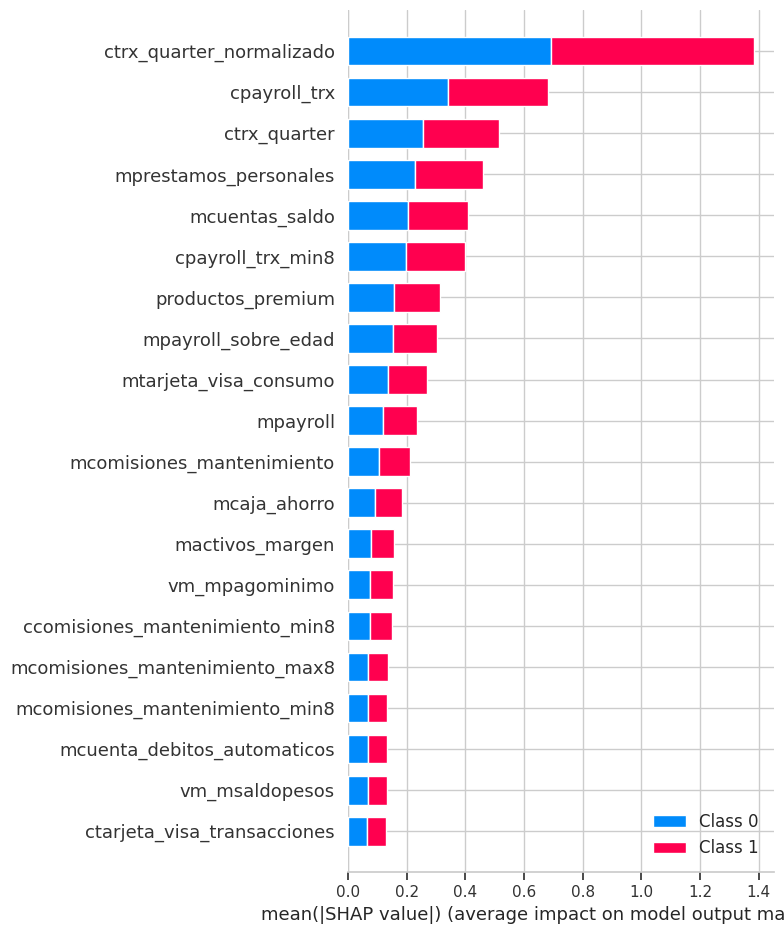

In [16]:
shap.summary_plot(shap_values, Xbajas[Xbajas.columns.difference(['foto_mes'])])


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

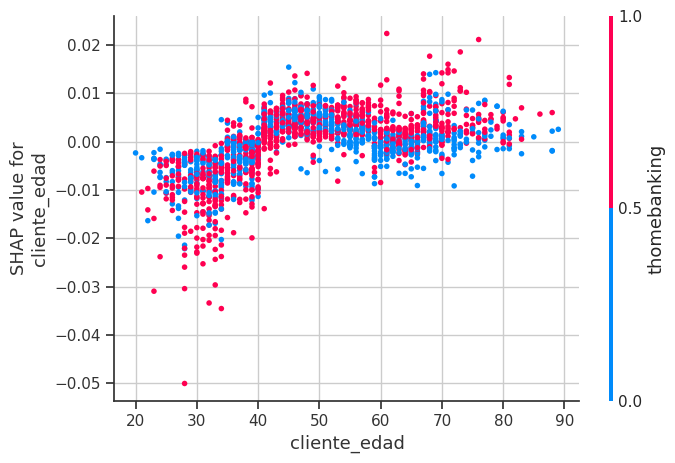

In [17]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas[Xbajas.columns.difference(['foto_mes'])])

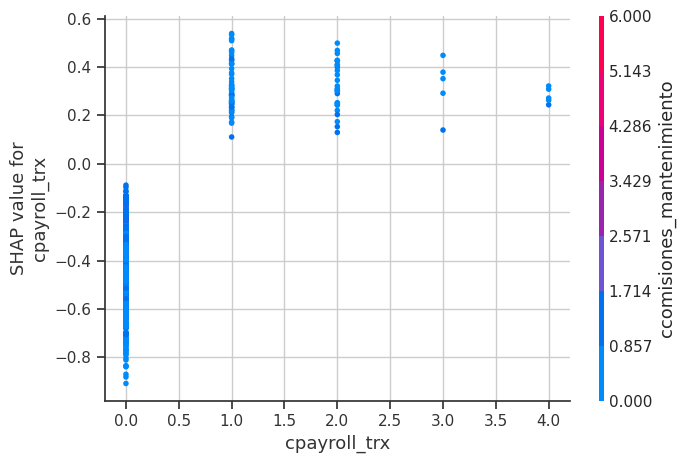

In [18]:
shap.dependence_plot("cpayroll_trx", shap_values[0], Xbajas[Xbajas.columns.difference(['foto_mes'])])

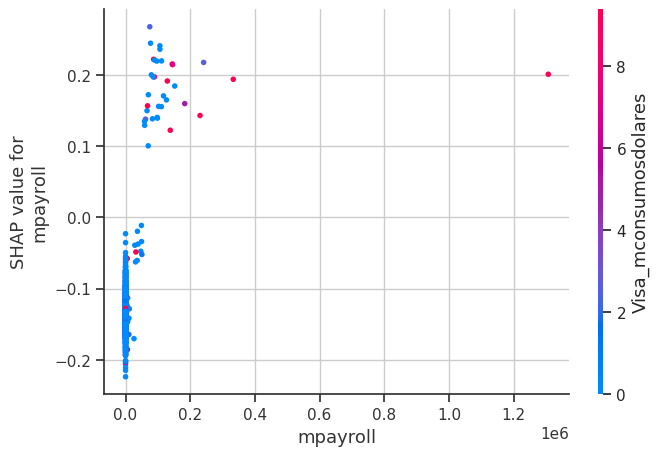

In [19]:
shap.dependence_plot("mpayroll", shap_values[0], Xbajas[Xbajas.columns.difference(['foto_mes'])])

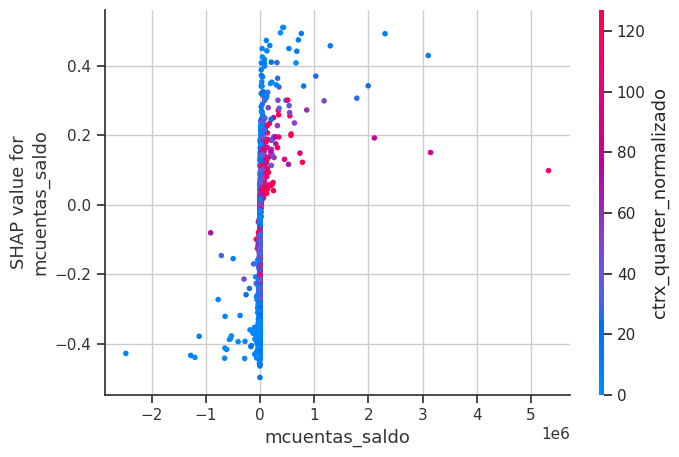

In [20]:
shap.dependence_plot("mcuentas_saldo", shap_values[0], Xbajas[Xbajas.columns.difference(['foto_mes'])])

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

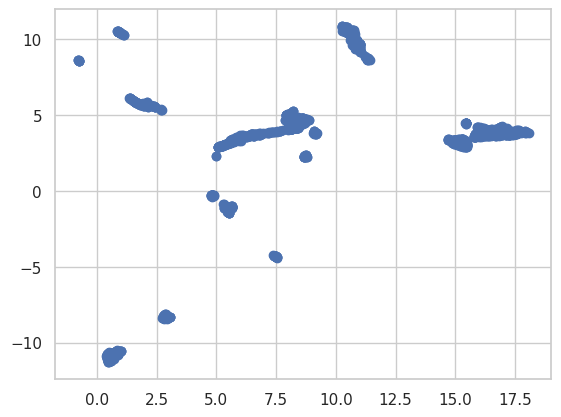

In [21]:
embedding_2d = UMAP(
  n_components=10, n_neighbors=40,random_state=539141
).fit_transform(shap_values[0],y=Xbajas['renta_clase'])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [22]:
embedding_2d = pd.DataFrame(embedding_2d)
embedding_2d = embedding_2d.add_prefix('umap_')
embedding_2d

umap_0               umap_1               umap_2  \
0                    2.30                 5.62                 6.47   
1                   17.60                 3.81                11.12   
2                    0.58               -10.77                12.77   
3                    9.15                 3.80                 9.83   
4                    1.93                 5.64                 7.41   
...                   ...                  ...                  ...   
1857                10.38                10.77                 9.04   
1858                 0.46               -11.12                12.67   
1859                15.47                 3.04                10.98   
1860                10.42                10.74                 9.00   
1861                17.11                 3.69                11.29   

                   umap_3               umap_4               umap_5  \
0                    3.47                 4.96                 6.87   
1                    4.27                 6.10                 8.06   
2                   22.31                -1.52                17.65   
3                    5.98                 0.99                 4.57   
4                    3.17                 5.69                 6.86   
...                   ...                  ...                  ...   
1857                -2.78                 1.43                 9.12   
1858                22.07                -1.37                17.76   
1859                 2.32                 9.12                 8.20   
1860                -2.73                 1.44                 9.15   
1861                 4.29                 6.45                 8.42   

                   umap_6               umap_7               umap_8  \
0                    2.77                 8.52                 2.50   
1                    5.83                 5.96                 2.16   
2                    5.41                 3.88                 6.49   
3                    3.42                 3.80                 1.55   
4                    2.67                 7.91                 2.99   
...                   ...                  ...                  ...   
1857                 2.81                 8.02                 2.91   
1858                 5.42                 4.15                 6.41   
1859                 6.42                 3.89                 3.48   
1860                 2.77                 7.96                 2.91   
1861                 5.90                 5.86                 2.35   

                   umap_9  
0                    8.97  
1                   10.01  
2                    0.06  
3                    9.12  
4                    9.28  
...                   ...  
1857                10.51  
1858                 0.13  
1859                 7.41  
1860                10.49  
1861                 9.81  

[1862 rows x 10 columns]

In [23]:
Xbajas_umap = pd.concat([Xbajas.reset_index(),embedding_2d.reset_index()],axis=1)
Xbajas_umap.filter(regex='^umap_',axis=1)['umap_0'].shape

(1862,)

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

In [35]:
from sklearn.cluster import KMeans

In [38]:
labels = KMeans(n_clusters = 4, random_state=1234).fit_predict(Xbajas_umap.filter(regex='^umap_',axis=1))
pd.Series(labels).value_counts()

1    681
0    625
3    325
2    231
dtype: int64

In [33]:
labels = DBSCAN(eps=8.5).fit_predict(Xbajas_umap.filter(regex='^umap_',axis=1))
pd.Series(labels).value_counts()

0    1631
1     197
2      34
dtype: int64

In [39]:
Xbajas_umap['cluster'] = labels

In [33]:

cols = [col for col in Xbajas_umap.columns if Xbajas_umap[col].isna().all().sum() == 0]
    
        

### ggpaires

In [126]:
Xbajas_umap_pair = Xbajas_umap
Xbajas_umap_pair['cluster'] = Xbajas_umap_pair.cluster.apply(lambda x: str(x))

In [130]:
Xbajas_umap_pair.cluster.describe()

count     6557
unique       4
top          0
freq      5209
Name: cluster, dtype: object

In [139]:
Xbajas_umap_pair[['cliente_edad','cliente_antiguedad','mrentabilidad','cpayroll_trx']]

cliente_edad  cliente_antiguedad  mrentabilidad  cpayroll_trx
0               84                 314    2102.692699             0
1               61                 314    2628.804398             0
2               72                 312      64.468855             0
3               60                 153     530.882838             0
4               53                 167    -693.733061             0
...            ...                 ...            ...           ...
6552            46                   8   -4518.424285             0
6553            73                   6     127.409030             0
6554            31                   3     126.030966             0
6555            66                   2       0.000000             0
6556            33                   1      25.209494             1

[6557 rows x 4 columns]

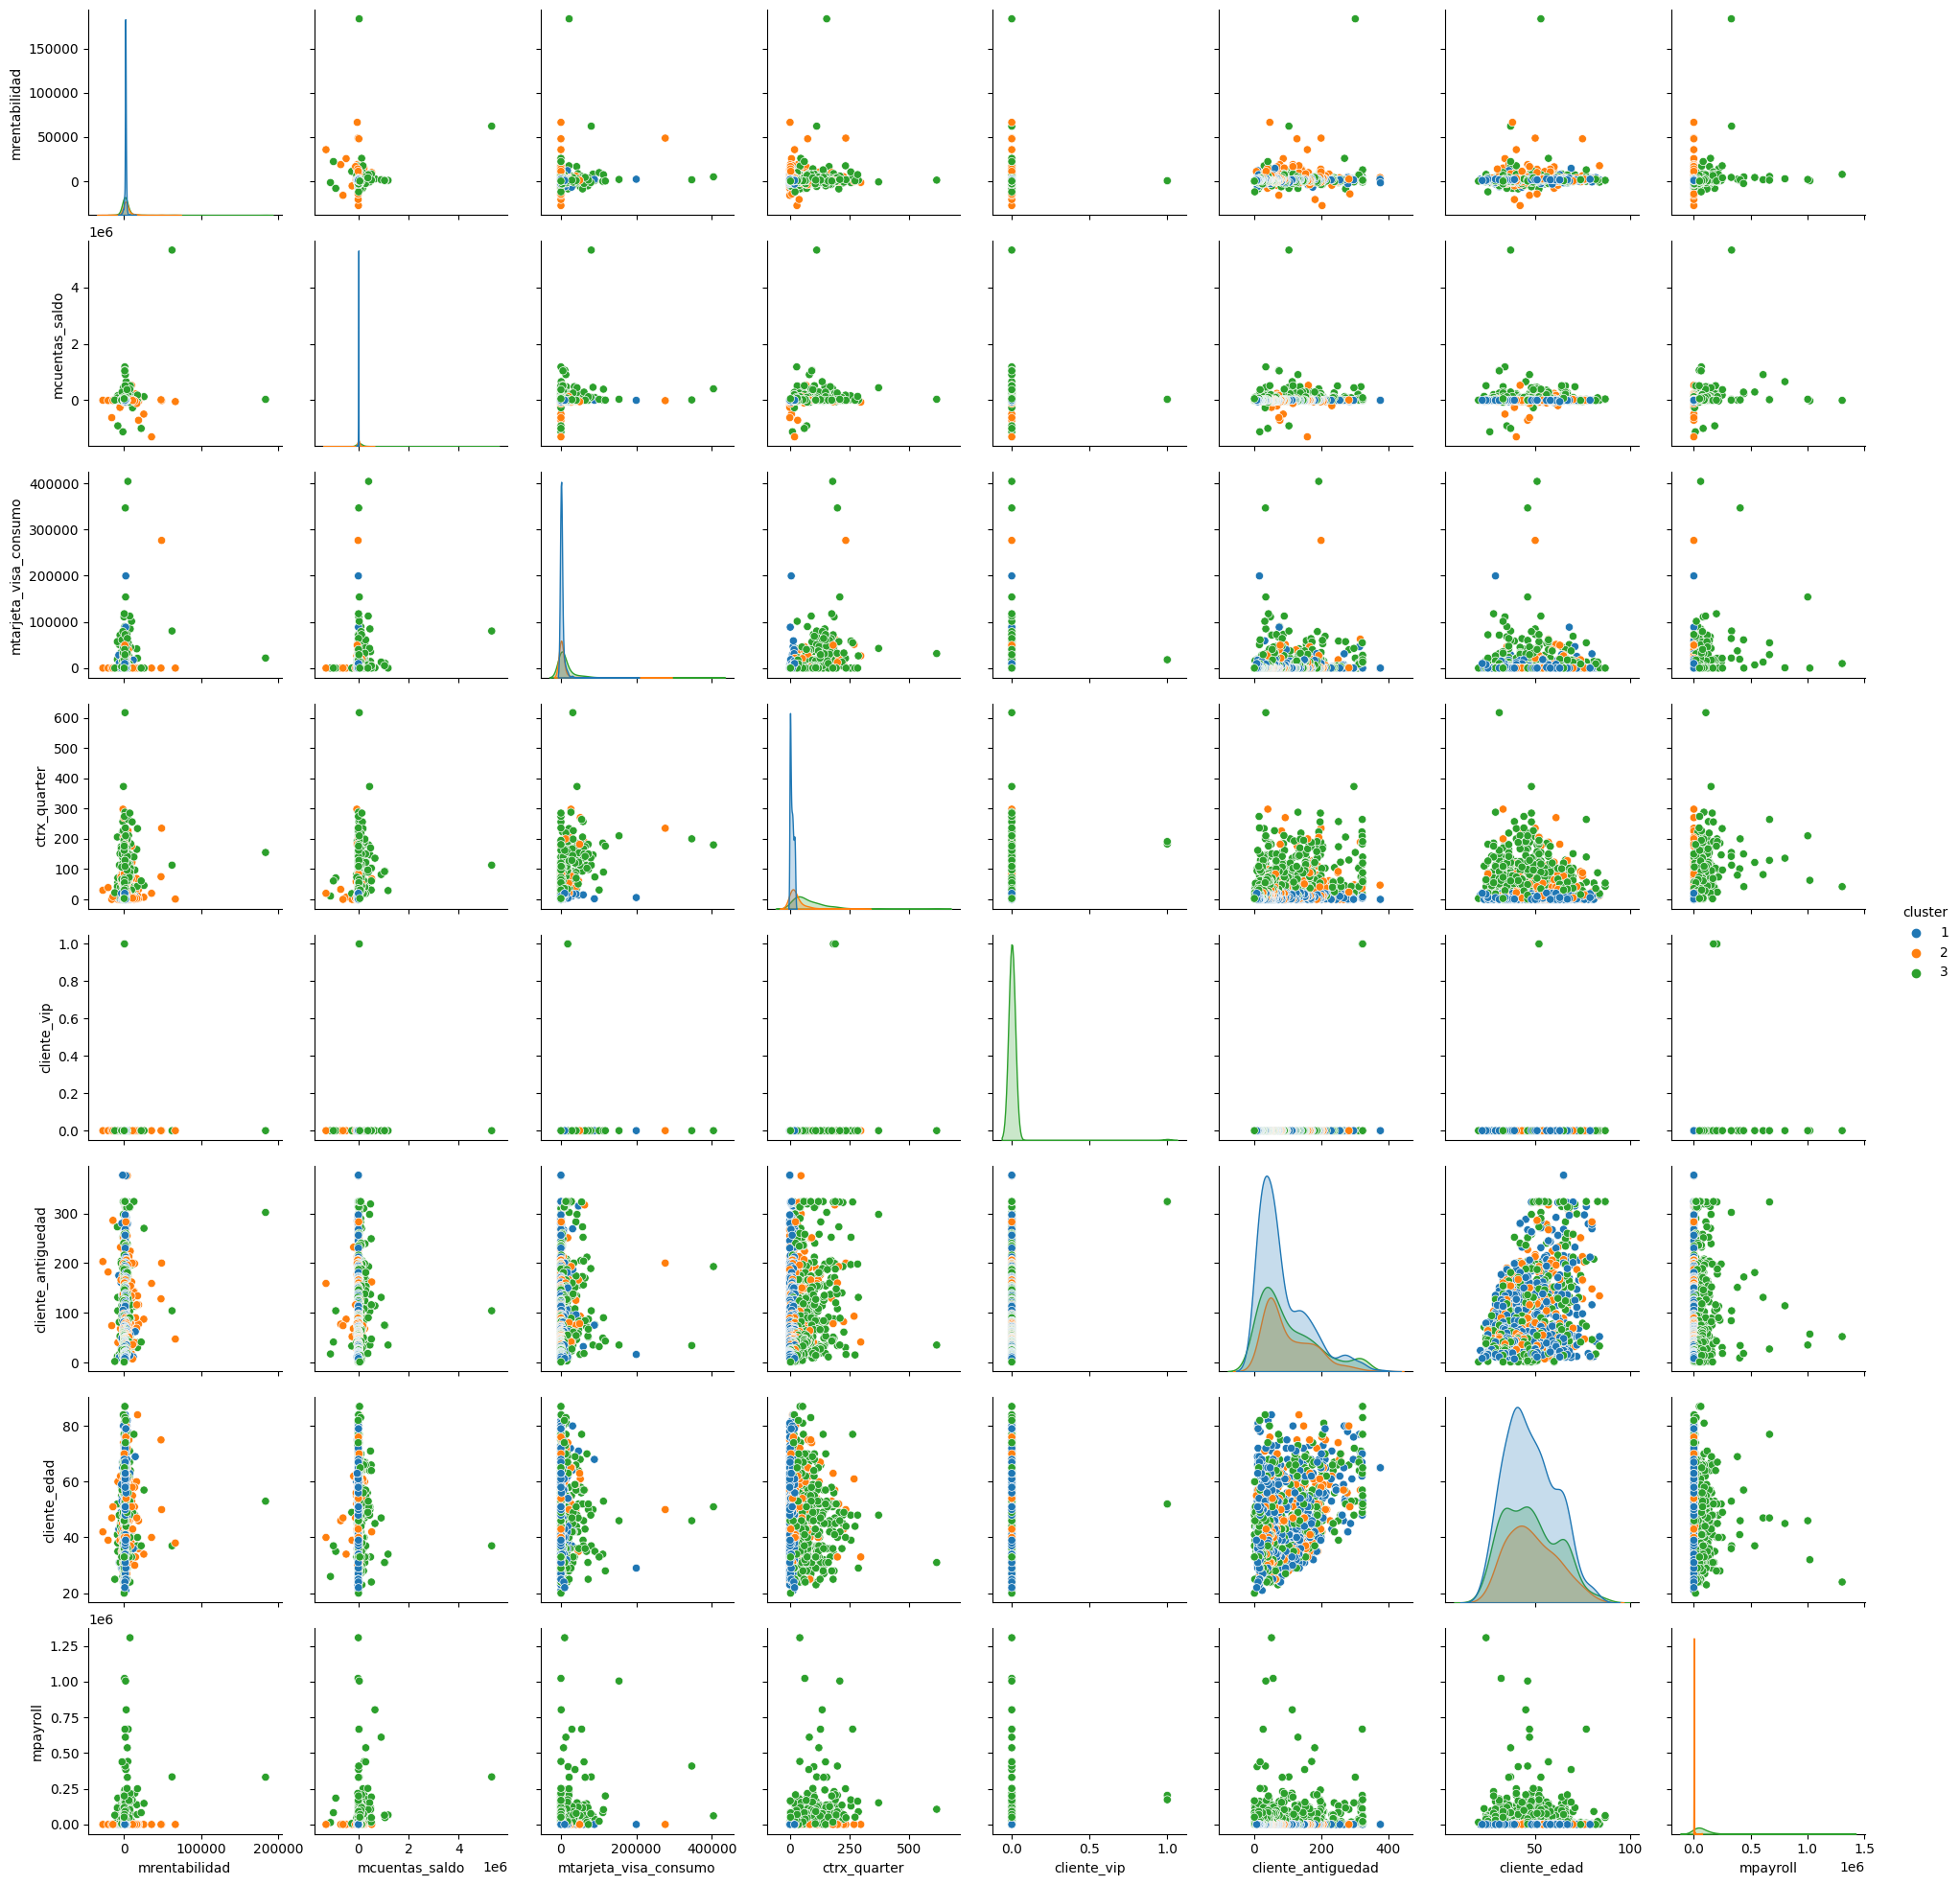

In [142]:
sns.pairplot(Xbajas_umap_pair.loc[Xbajas_umap_pair['cluster']!='0'][['mrentabilidad', 'mcuentas_saldo', 'mtarjeta_visa_consumo', 'ctrx_quarter', 'cliente_vip', 'cliente_antiguedad', 'cliente_edad', 'mpayroll','cluster']],hue='cluster')

In [120]:
g = sns.PairGrid(Xbajas_umap.all())
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

KeyError: True

In [33]:
Xbajas_umap.loc[Xbajas_umap['cluster']==3].mrentabilidad_annual.describe()

count                 343.00
mean              -10,588.61
std                17,629.35
min              -173,519.47
25%               -12,755.16
50%                -5,350.21
75%                -1,329.85
max                51,778.64
Name: mrentabilidad_annual, dtype: float64

In [34]:
Xbajas_umap.loc[Xbajas_umap['cluster']==2].mrentabilidad_annual.describe()

count                 594.00
mean               -4,888.80
std                10,815.45
min              -110,105.32
25%                -5,890.89
50%                -1,130.07
75%                    91.05
max                25,025.93
Name: mrentabilidad_annual, dtype: float64

In [35]:
Xbajas_umap.loc[Xbajas_umap['cluster']==1].mrentabilidad_annual.describe()

count               2,865.00
mean                8,390.93
std                 7,678.34
min               -54,736.90
25%                 4,102.91
50%                 7,248.18
75%                11,886.85
max               176,571.08
Name: mrentabilidad_annual, dtype: float64

In [36]:
Xbajas_umap.loc[Xbajas_umap['cluster']==0].mrentabilidad_annual.describe()

count               2,176.00
mean               35,799.27
std                77,763.54
min               -81,486.49
25%                14,073.01
50%                22,366.84
75%                34,346.91
max             2,339,247.18
Name: mrentabilidad_annual, dtype: float64

### sigue

In [40]:
scaler = StandardScaler()

In [41]:
Xbajas_umap.groupby('cluster').aggregate({'cpayroll_trx':np.mean})

cpayroll_trx
cluster                     
0                       0.12
1                       0.08
2                       0.03
3                       0.03

In [42]:
Xbajas_umap.groupby('cluster').aggregate({'cpayroll_trx':np.max})

cpayroll_trx
cluster              
0                   4
1                   4
2                   2
3                   4

In [43]:
Xbajas_umap.groupby('cluster').aggregate({'cpayroll_trx_max8':np.mean})

cpayroll_trx_max8
cluster                     
0                       0.47
1                       0.34
2                       0.24
3                       0.14

In [44]:
Xbajas_umap.groupby('cluster').aggregate({'cpayroll_trx_max8':np.mean})

cpayroll_trx_max8
cluster                     
0                       0.47
1                       0.34
2                       0.24
3                       0.14

In [112]:
cluster_labels = None
if cluster_labels is None:
    cluster_labels = range(4)

for i,j in zip(['a','a','c','d'],cluster_labels):
    print(i,j)




a 0
a 1
c 2
d 3


In [160]:
def plot_radars(df,categories,n_clusters=4,cluster_field='cluster',cluster_labels=None,conjunta=True,scaler='standard',lmh=[0.05,0.15,0.3]):
    if scaler == 'minmax':
        from sklearn.preprocessing import RobustScaler as Scaler
    elif scaler == 'standard':
        from sklearn.preprocessing import StandardScaler as Scaler
    else:
        Scaler = scaler

    if cluster_labels is None:
        cluster_labels = range(n_clusters)

    df_cat = df[categories+[cluster_field]]
    df_cat[categories] = Scaler().fit_transform(df_cat[categories])
    
    
    N = len(categories)

    fig = plt.figure(figsize=(18,25))

    #for i,j,cl in zip([0,0,1,1],[0,1,0,1],range(4)):
    subplots = [n_clusters*100 + 10 + i+1 for i in range(n_clusters)]
    for i,cl in zip(subplots,cluster_labels):
        ax = fig.add_subplot(i, polar=True)
        values = df_cat[categories].loc[df_cat['cluster']==cl].aggregate(np.mean).values.flatten().tolist()
        values += values[:1]
        #values

        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]
        #theta = radar_factory(N, frame='polygon')
        #theta = np.linspace(0, 2*np.pi, N, endpoint=False)

        # Initialise the spider plot
        #categories = ['ctrx_quarter','cpayroll_trx','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales','mpasivos_margen']
        #categories_relabeled = ['movimientos_trimestre', 'acred_haberes','consumos_tarjeta','saldo_en_cuentas','deuda_prestamos_personales','margen_por_pasivos']
        
        plt.xticks(angles[:-1], categories, color='grey', size=10)

        # Draw one axe per variable + add labels
    
        # Draw ylabels
        #ax.set_theta_offset(pi)
        prop = str(round(df_cat.loc[df_cat['cluster']==cl].shape[0]/df_cat.shape[0] * 100,0))+'%'
        ax.set_title('cluster '+ str(cl) + ', '+ prop + ' de las bajas')
        #ax.annotate(str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%',xy=(0.5,0.1),xycoords = 'subfigure fraction')

        #plt.yticks([0,1,2,3,4], [[0,1,2,3,4]], color="grey", size=7)
        #plt.ylim(0,40)
        for idx, an in enumerate(angles):
            plt.text(an, round(values[idx],2), str(round(values[idx],2)), color="grey", size=10)
            #plt.text(an, blue_values[idx], str(blue_values[idx]), color="black", size=16)

        
        
        # Plot data
        ax.plot(angles, values)
        
        # Fill area
        ax.fill(angles, values, 'b', alpha=0.1)

        ax.set_yticks(lmh,labels=['low','mid','high'], color='blue',size=8)

        # Show the graph

    plt.show()

    if conjunta:
        N = len(categories)

        fig = plt.figure(figsize=(4,4))
        ax2 = plt.subplot(111, polar=True)
        plt.xticks(angles[:-1], categories, color='grey', size=10)
        plt.yticks([], [], color="grey", size=7)

        #for i,j,cl in zip([0,0,1,1],[0,1,0,1],range(4)):
        for cl in cluster_labels:
            values = df_cat[categories].loc[df_cat['cluster']==cl].aggregate(np.mean).values.flatten().tolist()
            values += values[:1]
            values

            angles = [n / float(N) * 2 * np.pi for n in range(N)]
            angles += angles[:1]

            # Initialise the spider plot
            #categories = ['ctrx_quarter','cpayroll_trx','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales','mpasivos_margen']
            #categories_relabeled = ['movimientos_trimestre', 'acred_haberes','consumos_tarjeta','saldo_en_cuentas','deuda_prestamos_personales','margen_por_pasivos']
            
            
            # Draw one axe per variable + add labels
            
            
            # Draw ylabels
            #ax.set_theta_offset(pi)
            prop = str(round(df_cat.loc[df_cat['cluster']==cl].shape[0]/df_cat.shape[0] * 100,0))+'%'
            label = 'cluster '+ str(cl) + ', '+ prop + ' de las bajas'
            #ax.set_title('cluster '+ str(cl) + ', '+ prop + 'del total')
            #ax.annotate(str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%',xy=(0.5,0.1),xycoords = 'subfigure fraction')

            
            #plt.ylim(0,40)
            
            # Plot data
            ax2.plot(angles, values, linewidth=2, linestyle='solid',label=label)
            
            # Fill area
            ax2.fill(angles, values, 'b', alpha=0.1)

        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        gridlines = ax2.yaxis.get_gridlines()
        for gl in gridlines:
            gl.get_path()._interpolation_steps = N

            # Show the graph
        plt.yticks(lmh,labels=['low','mid','high'], color='blue',size=6)
        plt.show()



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


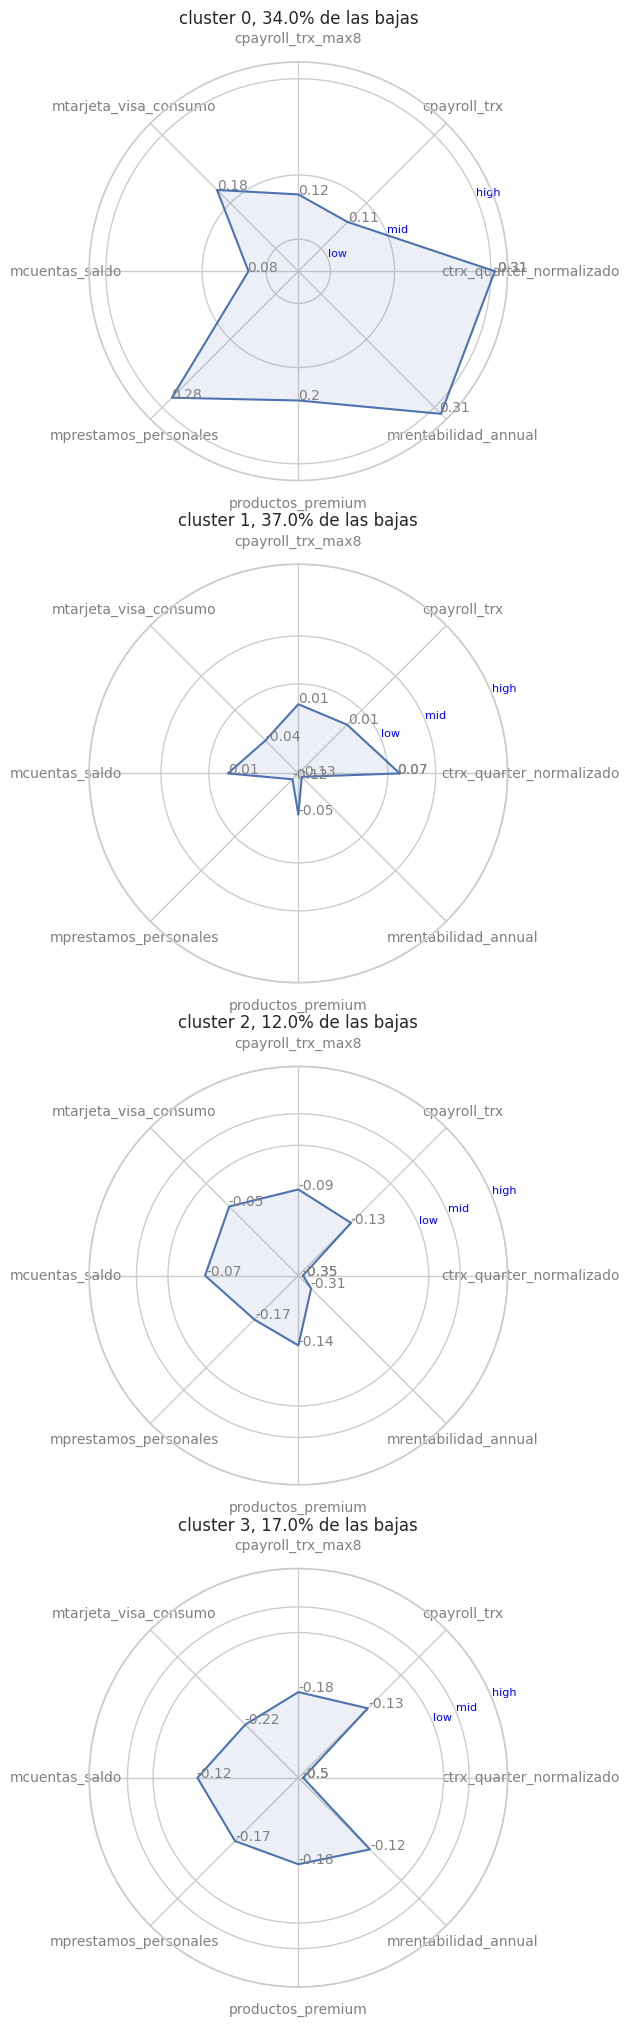

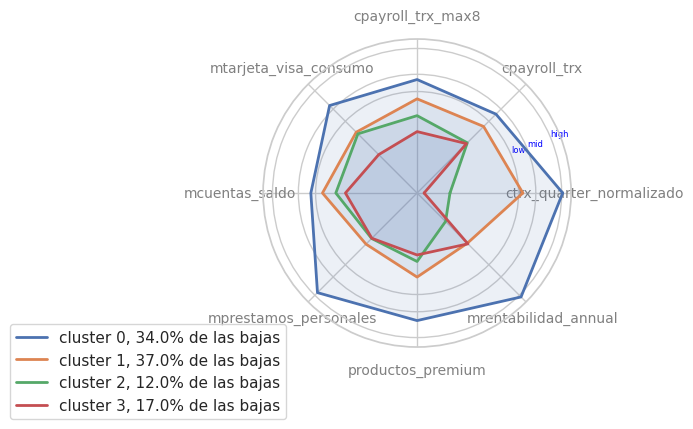

In [161]:
categories = ['ctrx_quarter_normalizado','cpayroll_trx','cpayroll_trx_max8','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales','productos_premium','mrentabilidad_annual']
plot_radars(df=Xbajas_umap,categories=categories,n_clusters=4,cluster_field='cluster',conjunta=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


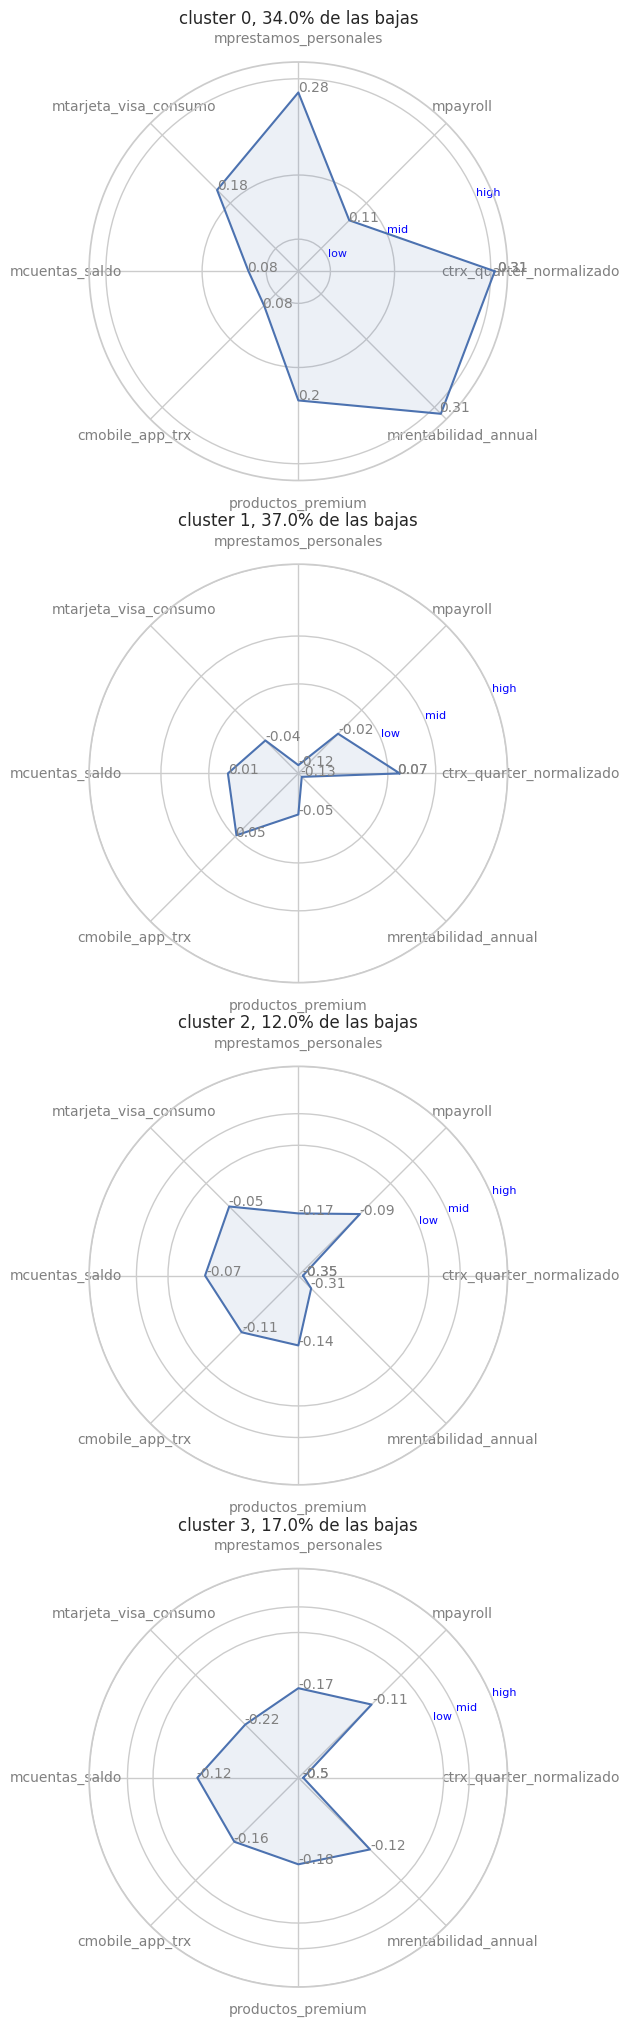

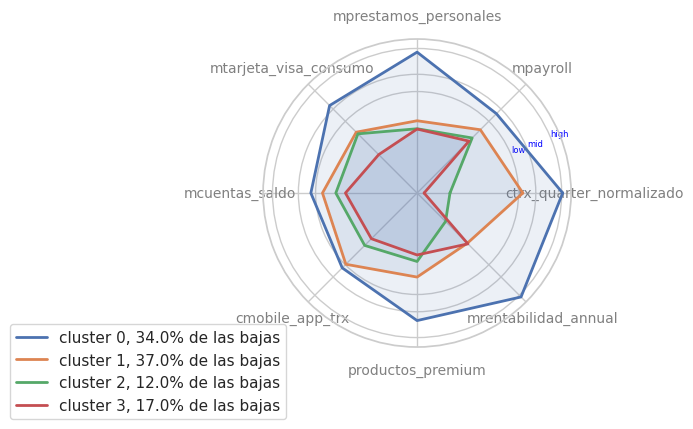

In [163]:
categories = ['ctrx_quarter_normalizado','mpayroll','mprestamos_personales','mtarjeta_visa_consumo','mcuentas_saldo','cmobile_app_trx','productos_premium','mrentabilidad_annual']
plot_radars(df=Xbajas_umap,categories=categories,n_clusters=4,cluster_field='cluster',conjunta=True)

### sigue

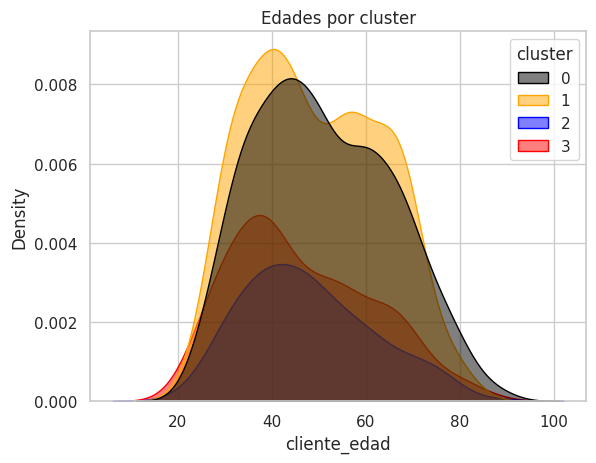

In [49]:
sns.kdeplot(data = Xbajas_umap, x='cliente_edad',hue='cluster',fill=True,alpha=0.5, palette = ['black','orange','blue','red'])

plt.title('Edades por cluster')
#plt.xlim(-200,10000)
plt.show()

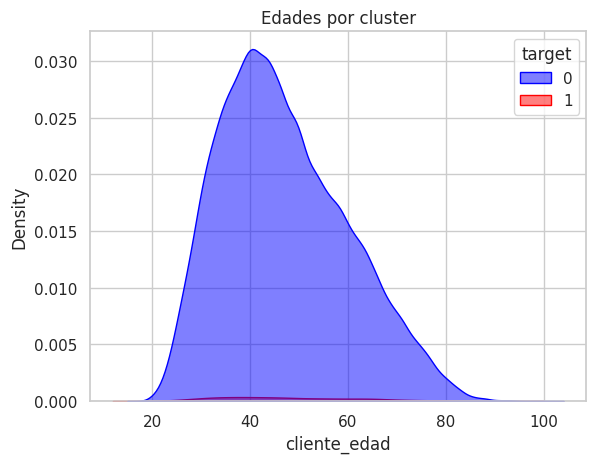

In [50]:
sns.kdeplot(data = df, x='cliente_edad',hue='target',fill=True,alpha=0.5, palette = ['blue','red'])

plt.title('Edades por cluster')
#plt.xlim(-200,10000)
plt.show()

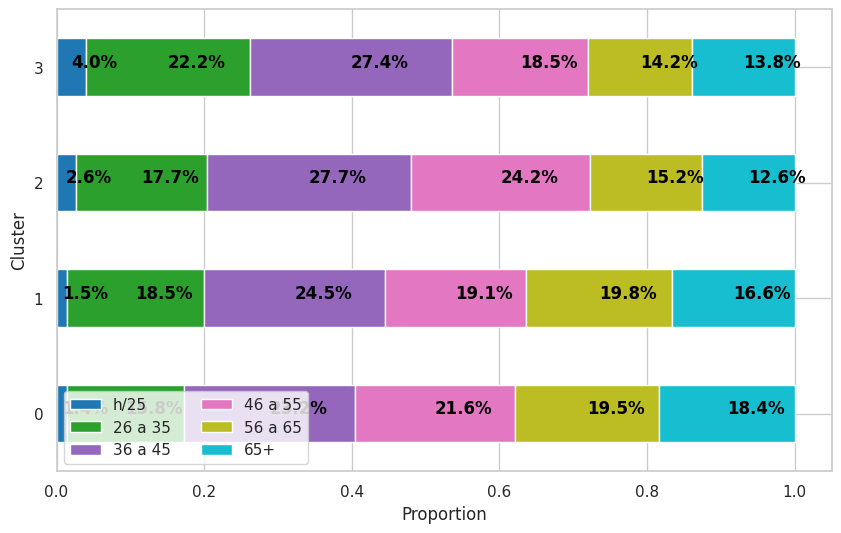

In [51]:
cross_tab_prop = pd.crosstab(index=Xbajas_umap['cluster'],
                             columns=Xbajas_umap['edad_ag'],
                             normalize="index")


cross_tab = pd.crosstab(index=Xbajas_umap['cluster'],
                        columns=Xbajas_umap['edad_ag'])

cross_tab_prop.plot(kind='barh', 
                        stacked=True, 
                        colormap='tab10', 
                        figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.ylabel("Cluster")
plt.xlabel("Proportion")



for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
#ax.bar(cross_tab_prop.index, cross_tab_prop.columns, width=1, edgecolor='white')
plt.show()

In [219]:

def plot_perc_bars(df1,df2,hue_field,
                    x_field1='cluster',x_field2='target',
                    hue_order=None,shrink=0.9,
                    title1='bajas',title2='todos',suptitle='',
                    labels1=['0:HighValue','1:HeavyUsers','2:LowValue','3:MidValue'],
                    labels2=['continúan','bajas'],
                    palette=None,legend=None):
    fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
    ax1 = sns.histplot(
        data=df1,
        x=x_field1, hue=hue_field, hue_order=hue_order,palette=palette,
        multiple="fill", stat="proportion",
        discrete=True, shrink=shrink, ax=ax1
    )
    ax1.set_xticks(range(len(df1[x_field1].unique())),labels=labels1)
    ax1.set_title(title1,size=14)
    if legend:
        ax1.legend(legend)

    ax2 = sns.histplot(
        data=df2,
        x=x_field2, hue=hue_field, hue_order=hue_order,palette=palette,
        multiple="fill", stat="proportion",
        discrete=True, shrink=shrink, ax=ax2
    )
    ax2.set_xticks(range(len(df2[x_field2].unique())),labels=labels2)
    ax2.set_title(title2,size=14)
    if legend:
        ax2.legend(legend)
    
    fig.suptitle(suptitle)
    plt.show()

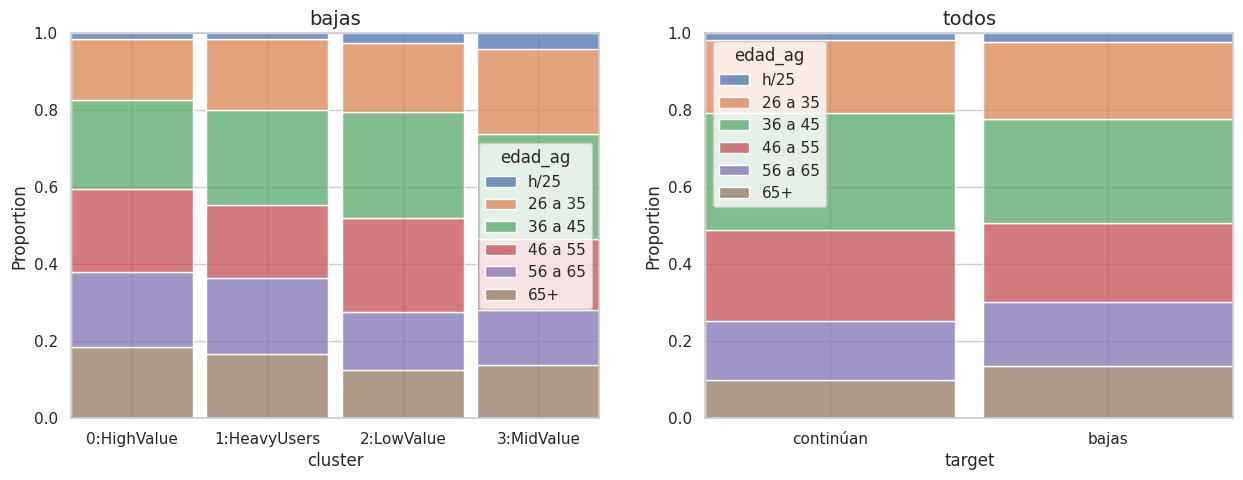

In [211]:
edades = ['h/25', '26 a 35','36 a 45', '46 a 55', '56 a 65','65+']
plot_perc_bars(Xbajas_umap,df,'edad_ag',hue_order=edades)

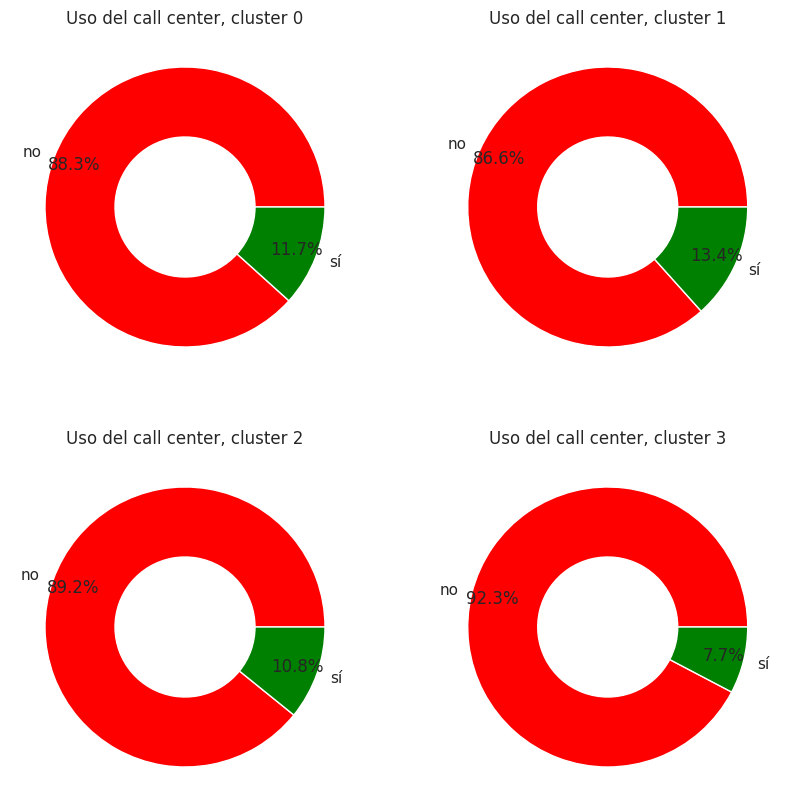

In [56]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(10,10))
fig = plt.gcf()
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
for cl,j,k in zip(range(4),[0,0,1,1],[0,1,0,1]):

        ax[j,k].pie(Xbajas_umap[Xbajas_umap.cluster == cl]['tcallcenter'].value_counts(), colors=['red','green'], labels=['no','sí'],
                autopct='%1.1f%%', pctdistance=0.85,wedgeprops=dict(width=.5))
        #plt.gca().add_artist(centre_circle)
        ax[j,k].set_title(f'Uso del call center, cluster {cl}')
  
# Displaying Chart
plt.show()

ValueError: 'label' must be of length 'x'

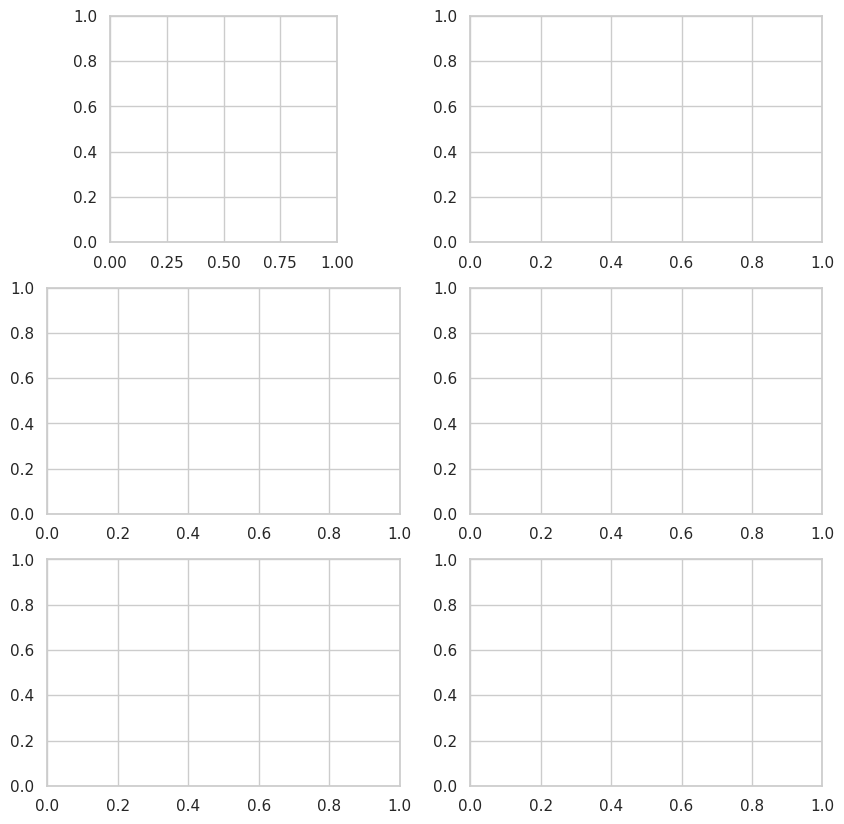

In [57]:
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(10,10))
fig = plt.gcf()
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
for ea,j,k in zip(['hasta 25', '26 a 35','36 a 45', '46 a 55', '56 a 65','mayor de 65'],[0,0,1,1,2,2],[0,1,0,1,0,1]):

        ax[j,k].pie(Xbajas_umap[Xbajas_umap.edad_ag == ea]['tcallcenter'].value_counts(), colors=['red','green'], labels=['no','sí'],
                autopct='%1.1f%%', pctdistance=0.85,wedgeprops=dict(width=.5))
        #plt.gca().add_artist(centre_circle)
        ax[j,k].set_title(f'Uso del call center en edad {ea}')
  
# Displaying Chart
plt.show()

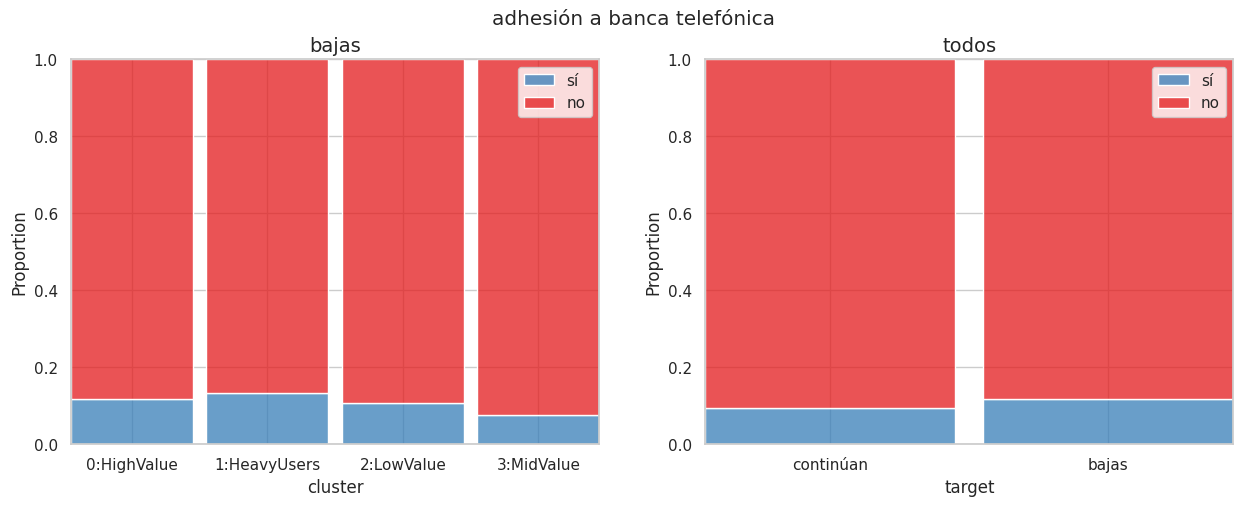

In [222]:
plot_perc_bars(Xbajas_umap,df,'tcallcenter',legend=['sí','no'],suptitle='adhesión a banca telefónica',palette='Set1')

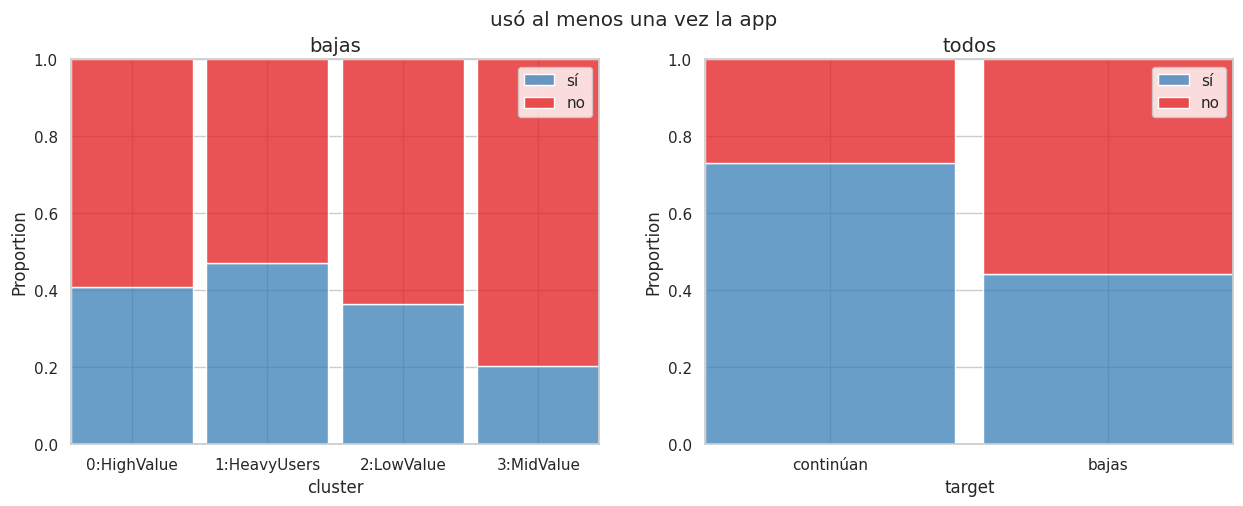

In [223]:
plot_perc_bars(Xbajas_umap,df,'uso_app_bool',legend=['sí','no'],suptitle='usó al menos una vez la app',palette='Set1')

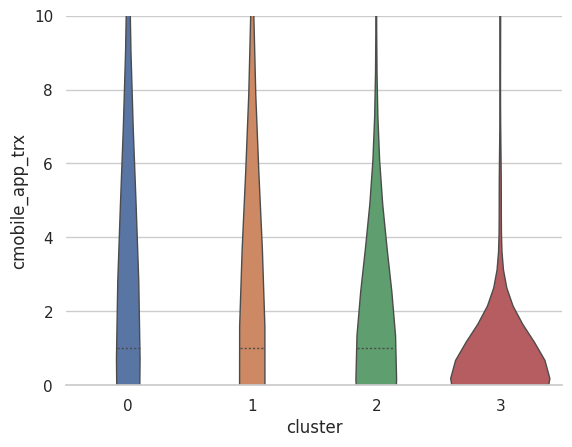

In [64]:

# Load the example tips dataset


# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=Xbajas_umap, x="cluster", y="cmobile_app_trx",
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=10,ymin=0)
sns.despine(left=True)

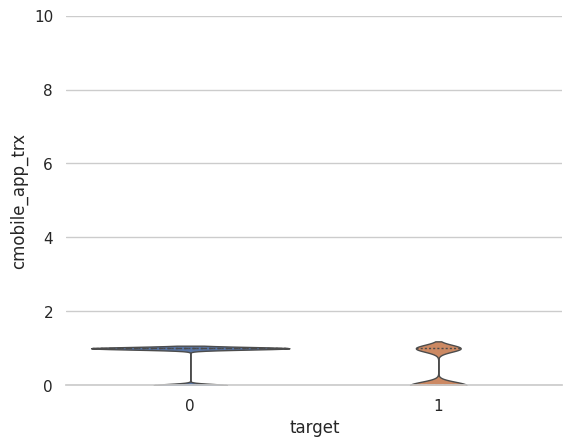

In [65]:
ax = sns.violinplot(data=df, x="target", y="cmobile_app_trx",
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=10,ymin=0)
sns.despine(left=True)

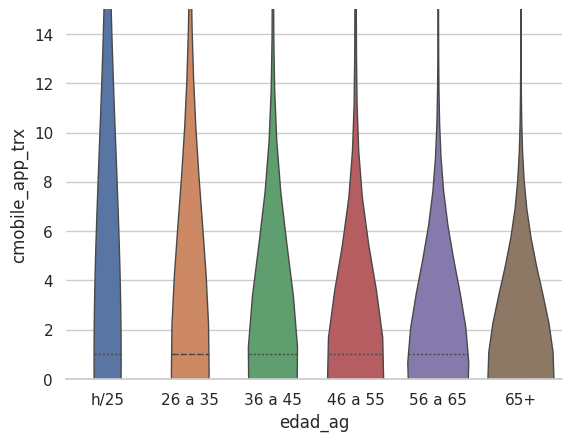

In [68]:
# Load the example tips dataset


# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=Xbajas_umap, x="edad_ag", y="cmobile_app_trx",
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=15,ymin=0)
sns.despine(left=True)

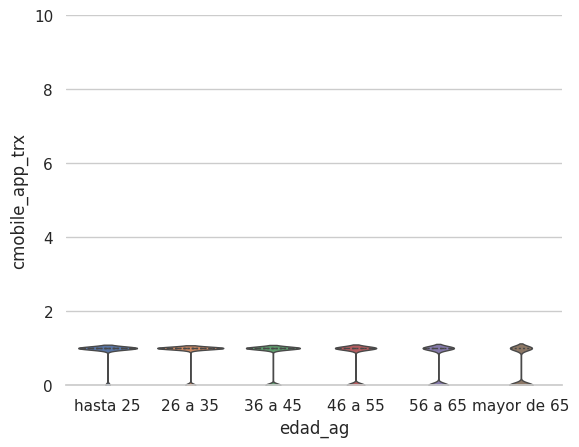

In [52]:
# Load the example tips dataset


# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=df, x="edad_ag", y="cmobile_app_trx",
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=10,ymin=0)
sns.despine(left=True)

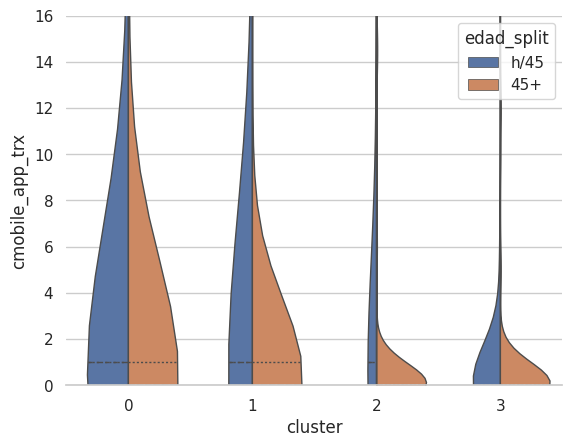

In [70]:

# Load the example tips dataset


# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=Xbajas_umap, x="cluster", y="cmobile_app_trx", split=True, hue='edad_split',
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=16,ymin=0)
sns.despine(left=True)

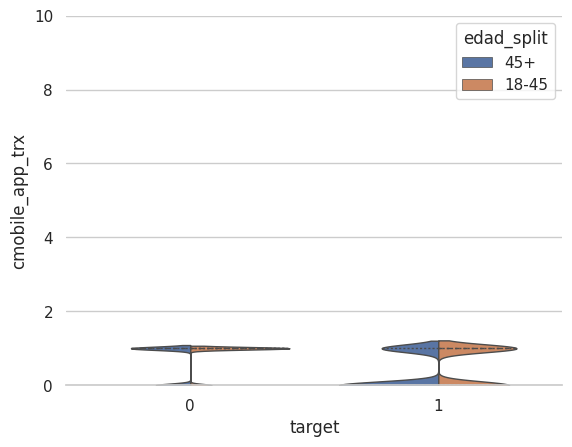

In [54]:
ax = sns.violinplot(data=df, x="target", y="cmobile_app_trx", split=True, hue='edad_split',
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=10,ymin=0)
sns.despine(left=True)

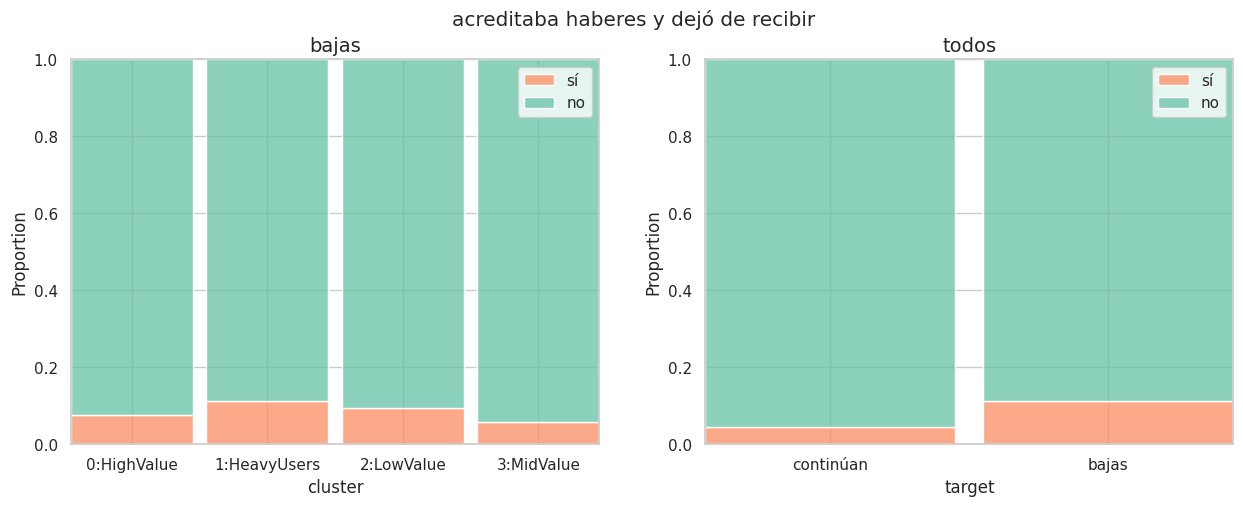

In [228]:
plot_perc_bars(Xbajas_umap,df,'perdio_haberes',legend=['sí','no'],suptitle='acreditaba haberes y dejó de recibir',palette='Set2')

In [254]:
def plot_density(df,var,clusters_labels=None,
                nrows=2,title='',title2='',esp=False,
                legend=None,
                palette=None):
    if not clusters_labels:
        clusters_labels = range(4)

    fig,ax=plt.subplots(nrows=nrows,ncols=int(len(clusters_labels)/nrows),figsize=(12,12))

    for cl,i,j in zip(clusters_labels,[0,0,1,1],[0,1,0,1]):
        ax[i,j] = sns.kdeplot(data = df.loc[df.cluster==cl], x=var,fill=True, ax=ax[i,j])

        ax[i,j].set_title(f'{title} cluster {cl}')
        ax[i,j].ticklabel_format(useOffset=False, style='plain')
        if cl == 0 and esp:
            ax[i,j].set_xlim(-100000,600000)
    plt.show()
    ax2 = sns.kdeplot(data = df, x=var,hue='cluster',fill=True,alpha=0.5, palette = palette)
    if legend:
        ax2.legend(legend)

    ax2.set_title(title2)
    if esp:
        plt.xlim(-150000,350000)
    plt.show()
#sns.despine(left=True)


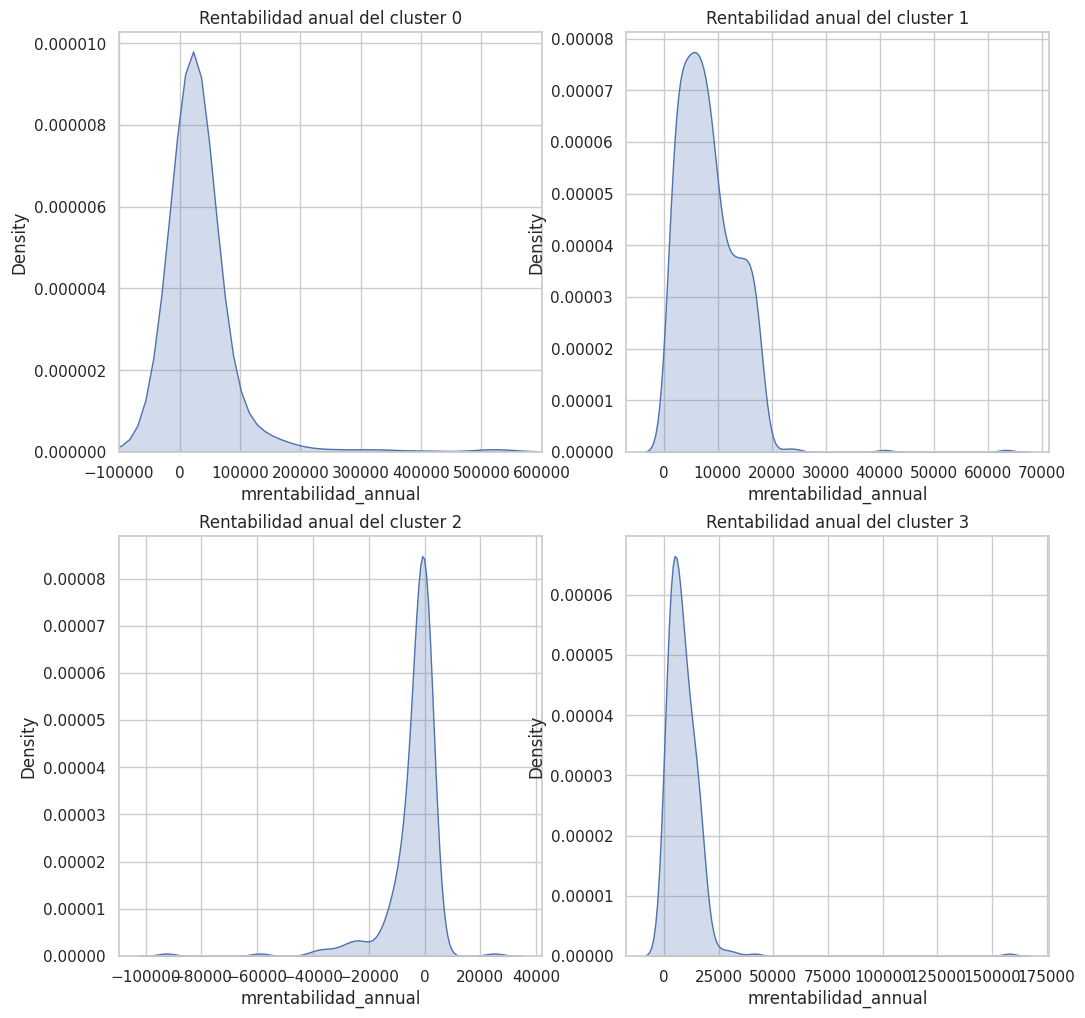

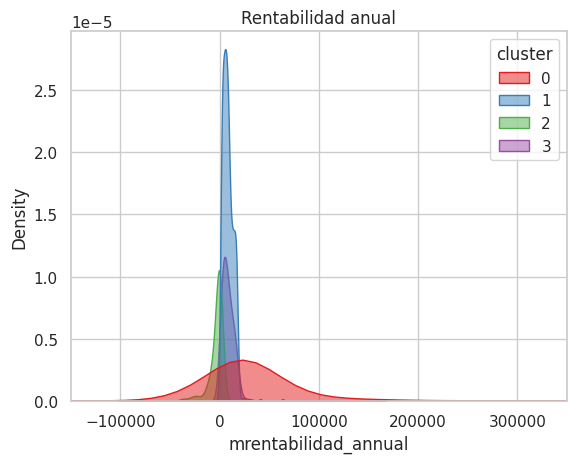

In [255]:
plot_density(Xbajas_umap,'mrentabilidad_annual',
            title='Rentabilidad anual del',
            title2='Rentabilidad anual',
            esp=True,palette='Set1',
            #legend=None
)


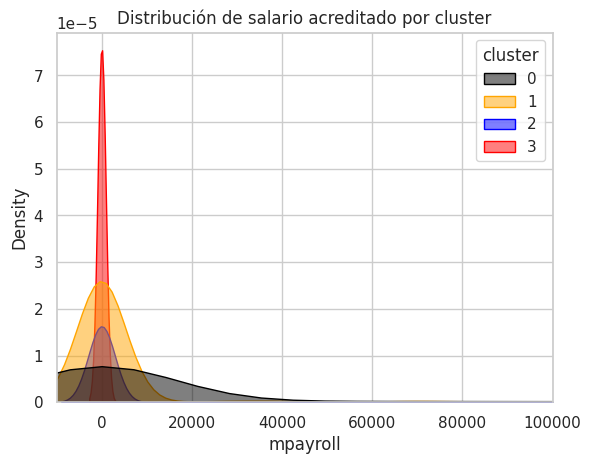

In [259]:
sns.kdeplot(data = Xbajas_umap, x='mpayroll',hue='cluster',fill=True,alpha=0.5, palette = ['black','orange','blue','red'])

plt.title('Distribución de salario acreditado por cluster')
plt.xlim(-10000,100000)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'cluster'

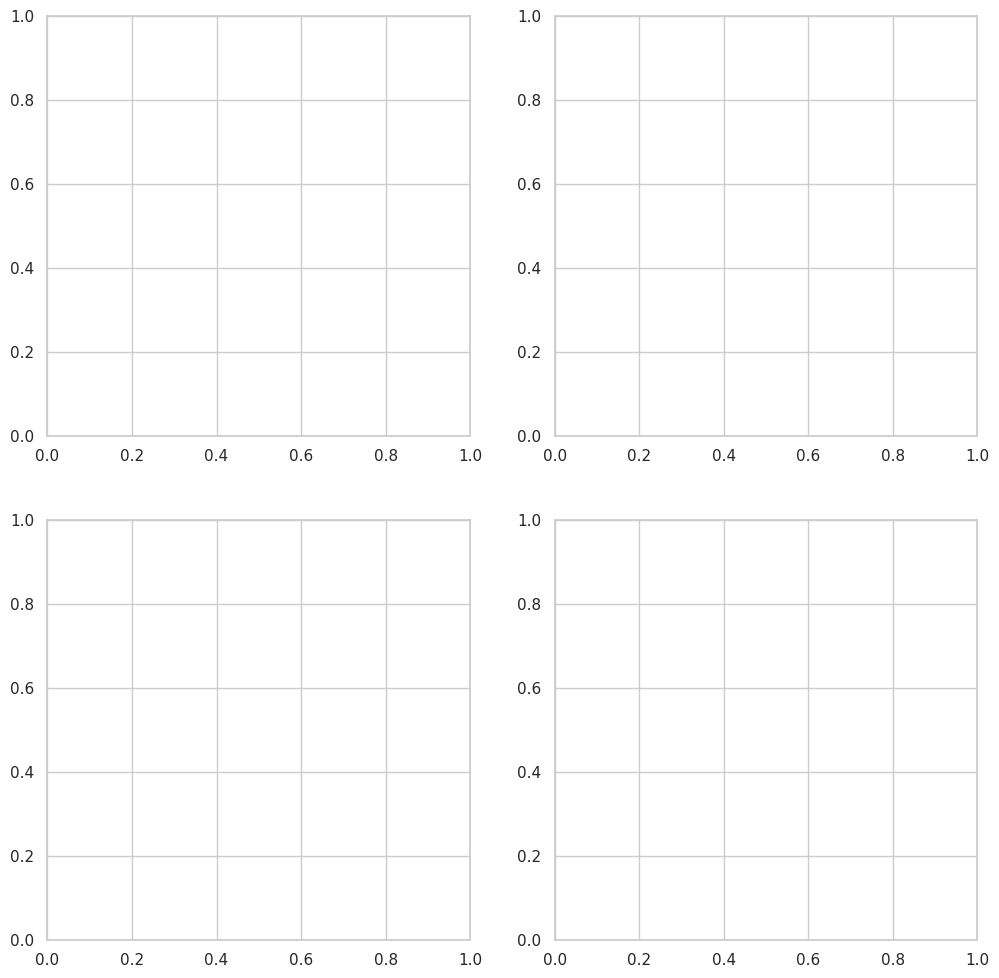

In [260]:
plot_density(df,'mpayroll',
            title='Distribución de salario acreditado del',
            title2='Distribución de salario acreditado por cluster',
            esp=False,palette='Set1',
            #legend=None
)


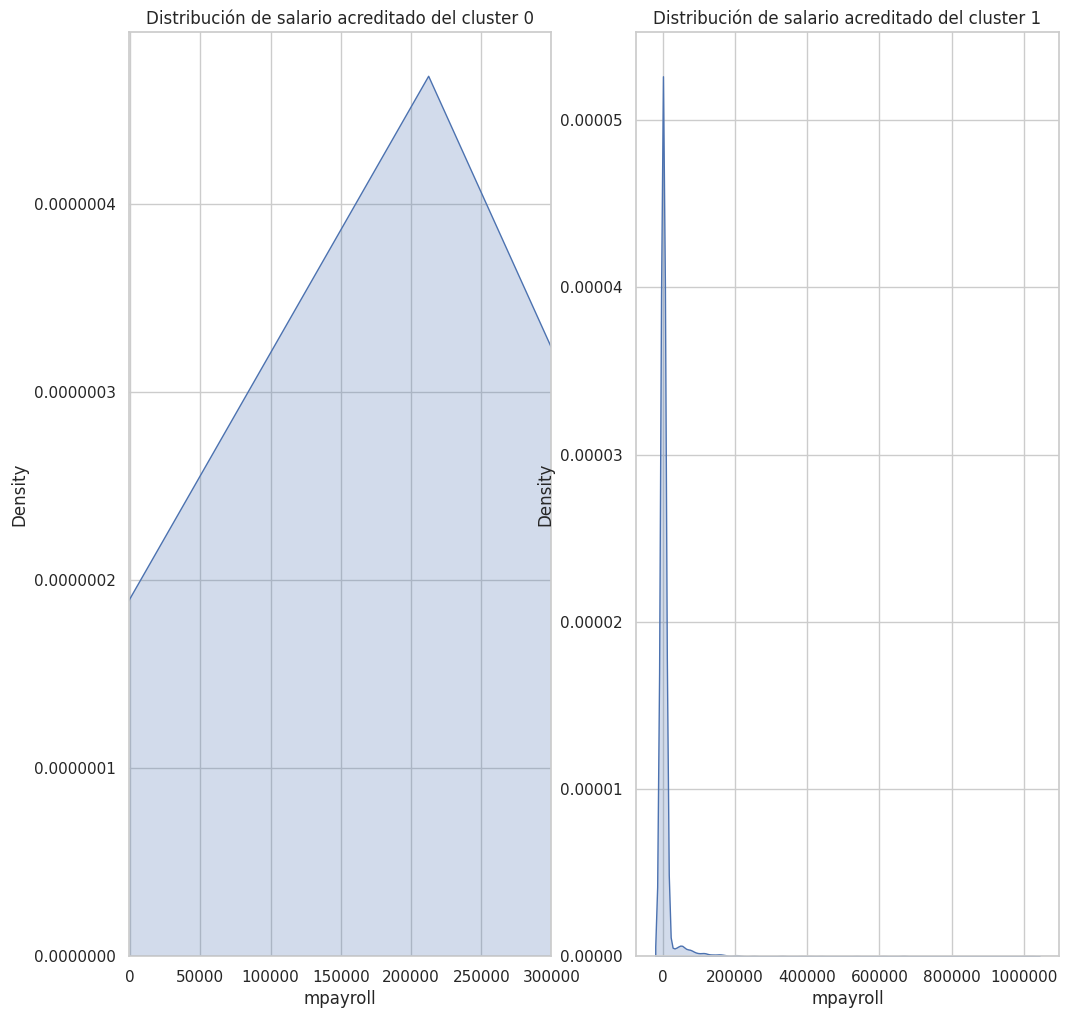

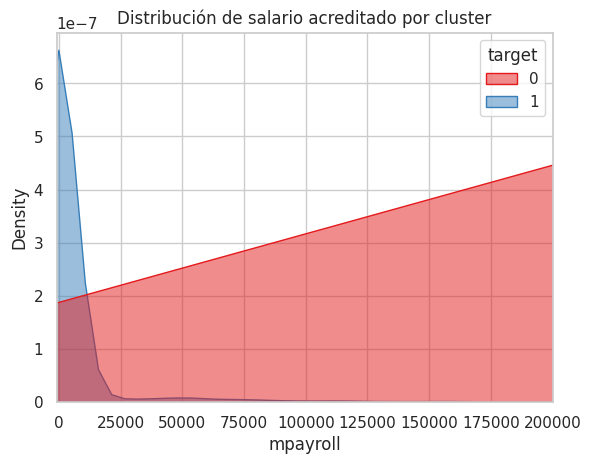

In [267]:
def plot_density_df(df,var,clusters_labels=None, cluster_field='cluster',
                nrows=1,title='',title2='',esp=False,
                legend=None,
                palette=None):
    if not clusters_labels:
        clusters_labels = range(4)

    fig,ax=plt.subplots(nrows=nrows,ncols=int(len(clusters_labels)/nrows),figsize=(12,12))

    for cl,i in zip(clusters_labels,[0,1]):
        ax[i] = sns.kdeplot(data = df.loc[df[cluster_field]==cl], x=var,fill=True, ax=ax[i])

        ax[i].set_title(f'{title} cluster {cl}')
        ax[i].ticklabel_format(useOffset=False, style='plain')
        if cl == 0 and esp:
            ax[i].set_xlim(-1000,300000)
    plt.show()
    ax2 = sns.kdeplot(data = df, x=var,hue=cluster_field,fill=True,alpha=0.5, palette = palette)
    if legend:
        ax2.legend(legend)

    ax2.set_title(title2)
    if esp:
        plt.xlim(-1000,200000)
    plt.show()
#sns.despine(left=True)

plot_density_df(df,'mpayroll',
            title='Distribución de salario acreditado del',
            title2='Distribución de salario acreditado por cluster',
            esp=True,palette='Set1',
            clusters_labels=[0,1], cluster_field='target'
            #legend=None
)


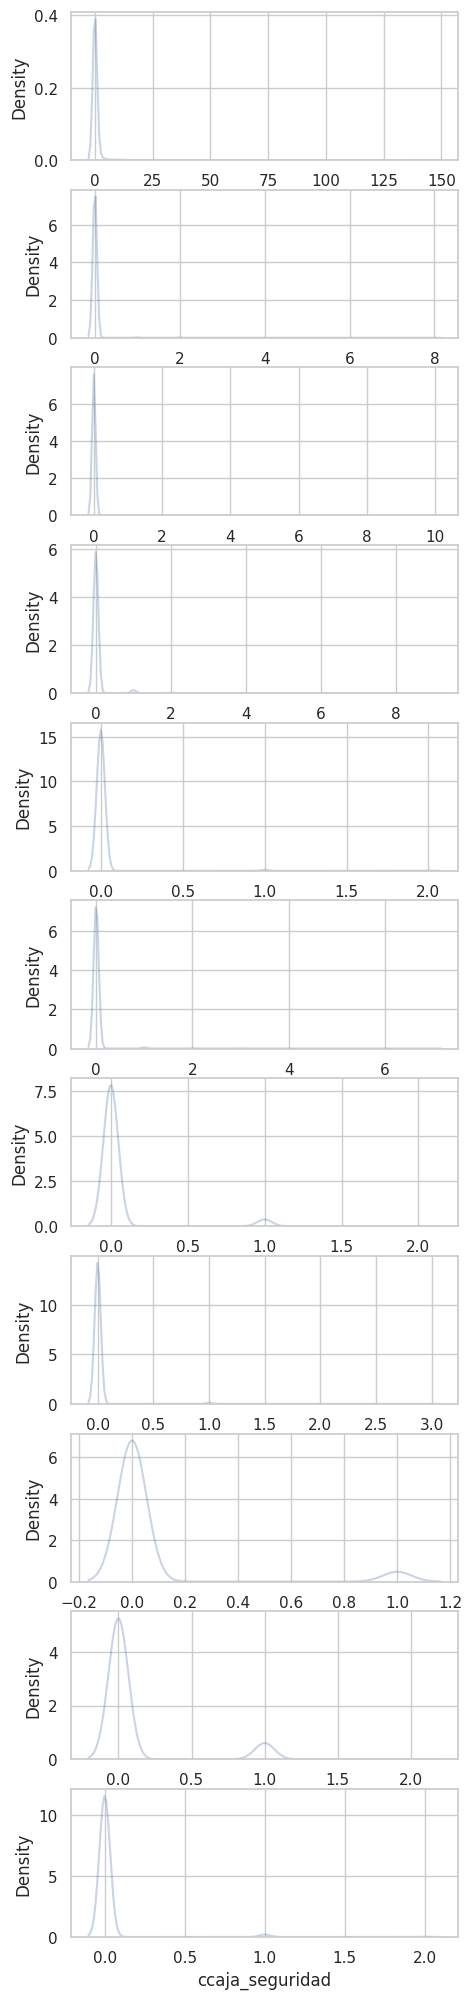

In [274]:
df_punt = Xbajas_umap.loc[Xbajas_umap.cluster==0]
var_list=['cprestamos_personales','cprestamos_prendarios','cprestamos_hipotecarios','cplazo_fijo','cinversion1','cinversion2','cseguro_vida','cseguro_auto','cseguro_vivienda','cseguro_accidentes_personales','ccaja_seguridad']
fig,ax = plt.subplots(ncols=1,nrows=len(var_list),figsize=(5,25))
for var,i in zip(var_list,range(len(var_list))):
        ax[i] = sns.kdeplot(data = Xbajas_umap, x=var,fill=False,alpha=0.3,ax=ax[i])
    

plt.show()

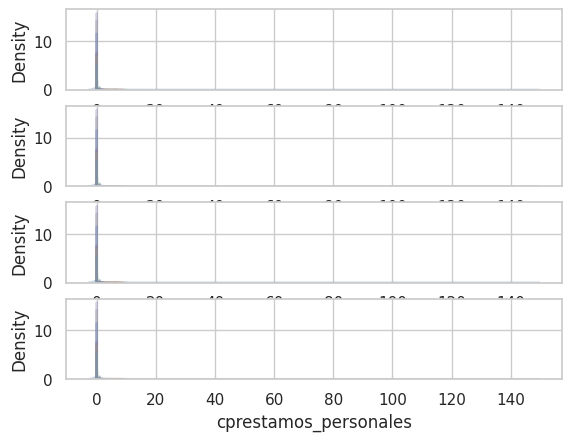

In [269]:
fig,ax=plt.subplots(ncols=1,nrows=4)
for cl in range(4):
    for var in ['cprestamos_personales','cprestamos_prendarios','cprestamos_hipotecarios','cplazo_fijo','cinversion1','cinversion2','cseguro_vida','cseguro_auto','cseguro_vivienda','cseguro_accidentes_personales','ccaja_seguridad']:
        ax[cl] = sns.kdeplot(data = Xbajas_umap, x=var,fill=False,alpha=0.3,ax=ax[cl])
    

plt.show()


In [277]:
Xbajas_ = Xbajas_umap[['cprestamos_personales','cprestamos_prendarios','cprestamos_hipotecarios','cplazo_fijo','cinversion1','cinversion2','cseguro_vida','cseguro_auto','cseguro_vivienda','cseguro_accidentes_personales','ccaja_seguridad','cluster']]

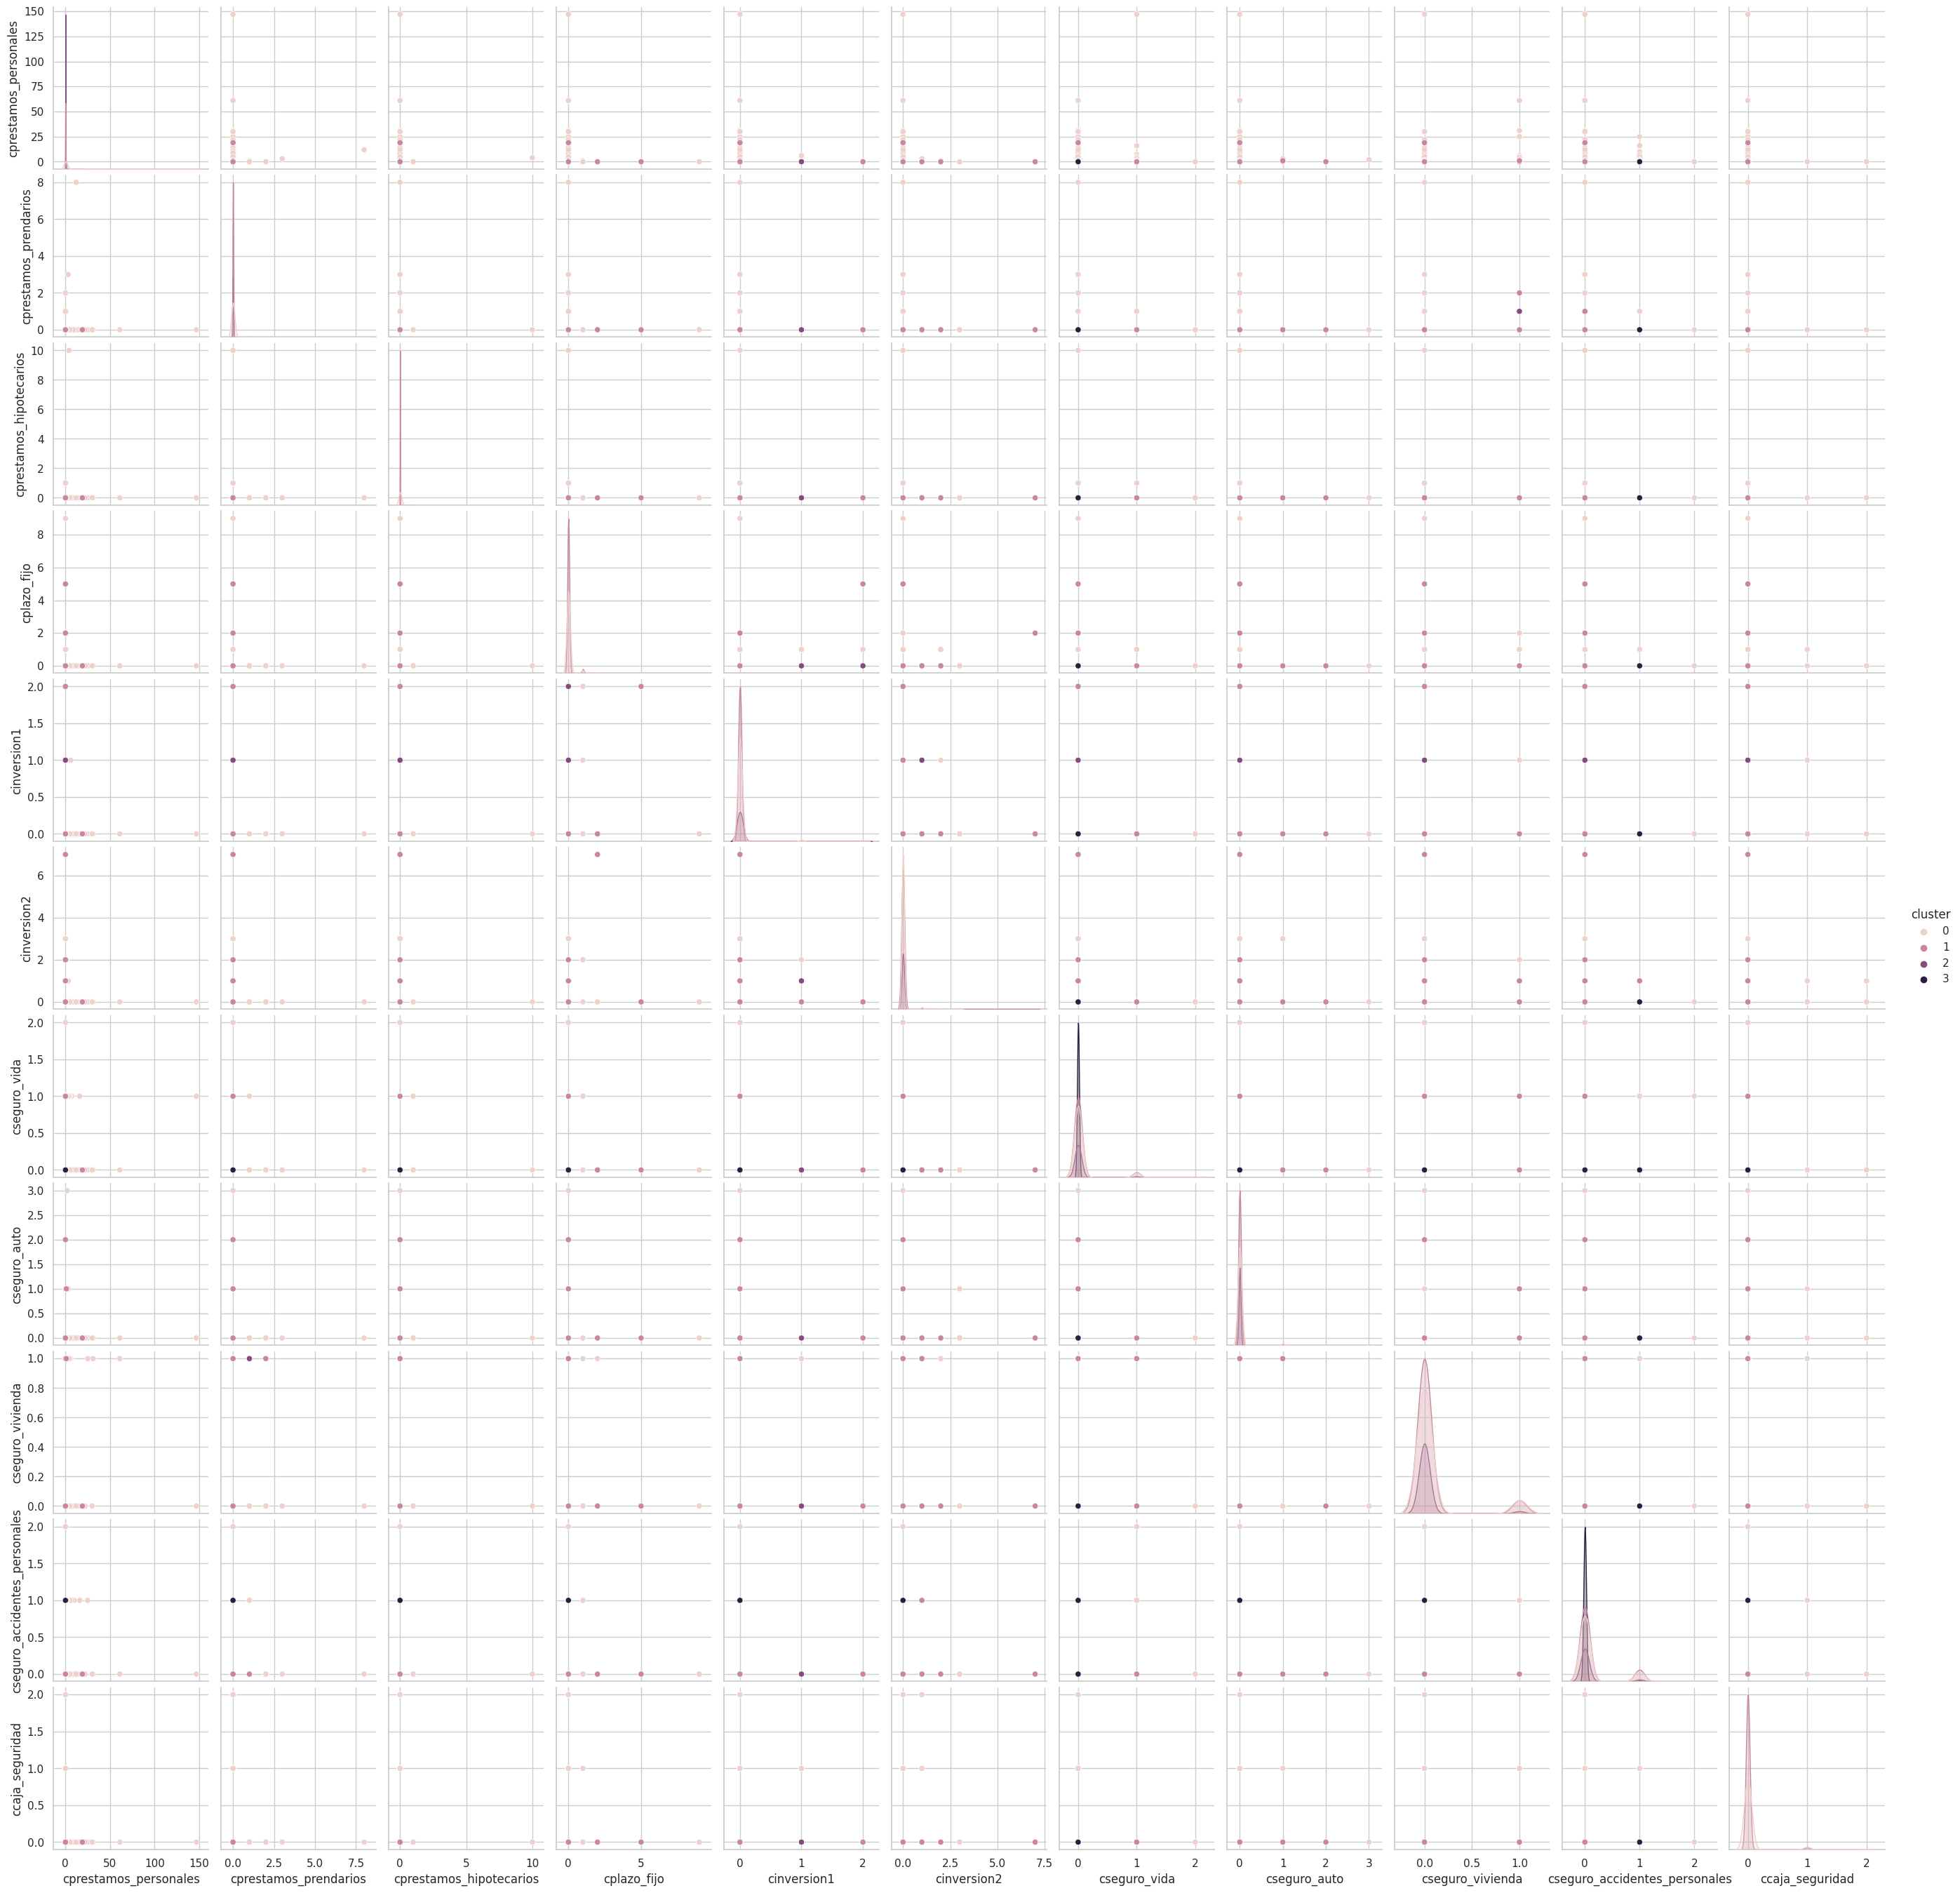

In [278]:
sns.pairplot(Xbajas_,hue='cluster')